In [1]:
setwd("~/jn_projects/cvpc_eqtls")

source("script/packages.R"  )
source("script/input_data.R")
source("script/functions.R" )

suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(cowplot))

In [68]:
.libPaths()

[1] "/frazer01/home/jennifer/software/R-4.1.0/lib64/R/library"

In [2]:
library(ashr)
library(mashr)

In [5]:
set.seed(5366)

# Run MASH using beta and se for SNP-gene pairs identified in the original analysis

# Input

In [15]:
# Get lead snps for each eqtl
eqtls = fread("/frazer01/home/matteo/documents/written/Cardips/cardiac_eqtls/submission_NatComm_2022_03_30/Table_S2.csv", data.table = F)
colnames(eqtls) = c("phenotype", "transcript_id", "gene_id", "gene_name", "gene_type", "type", "id", "chrom", "pos", "ref", "alt", "rsid", "beta", "se", "pval", "ntests", "fdr", "qval", "egene")
eqtls$type = as.integer(mapvalues(eqtls$type, from = c("Primary", paste("Conditional", c(1:5))), to = c(0:5)))
eqtls$qtl_id = paste(eqtls$transcript_id, eqtls$id)
eqtls = eqtls[eqtls$phenotype == "Gene" & eqtls$egene == "Yes",]
eqtls$egene = ifelse(eqtls$egene == "Yes", T, F)
eqtls$phenotype = ifelse(eqtls$phenotype == "Gene", "gene", "isoform")
nrow(eqtls)

inter = fread("/frazer01/home/matteo/documents/written/Cardips/cardiac_eqtls/submission_NatComm_2022_03_30/Table_S4.csv", data.table = F)
colnames(inter) = c("phenotype", "transcript_id", "gene_id", "type", "id", "interaction", "beta_int", "se_int", "pval_int", "fdr_int", "beta_1", "se_1", "pval_1", "qval_1", "beta_0", "se_0", "pval_0", "qval_0", "cell", "specific", "associated")
inter$type = as.integer(mapvalues(inter$type, from = c("Primary", paste("Conditional", c(1:5))), to = c(0:5)))
inter$qtl_id = paste(inter$transcript_id,  inter$id)
str(inter)


[1] 18030

'data.frame':	6366 obs. of  22 variables:
 $ phenotype    : chr  "Gene" "Gene" "Gene" "Gene" ...
 $ transcript_id: chr  "ENSG00000001460.18_7" "ENSG00000001460.18_7" "ENSG00000001460.18_7" "ENSG00000001460.18_7" ...
 $ gene_id      : chr  "ENSG00000001460.18_7" "ENSG00000001460.18_7" "ENSG00000001460.18_7" "ENSG00000001460.18_7" ...
 $ type         : int  0 0 0 0 0 0 0 0 1 1 ...
 $ id           : chr  "VAR_1_24731659_G_A" "VAR_1_24731659_G_A" "VAR_1_24731659_G_A" "VAR_1_24731659_G_A" ...
 $ interaction  : chr  "Arteria" "Aorta" "fibroblast" "smooth muscle" ...
 $ beta_int     : num  -0.619 -0.745 -5.87 -1.076 0.458 ...
 $ se_int       : num  0.0996 0.1132 1.2387 0.1713 0.0971 ...
 $ pval_int     : num  4.51e-10 8.78e-10 1.07e-06 2.62e-10 1.50e-06 ...
 $ fdr_int      : num  8.13e-06 1.58e-05 1.92e-02 4.73e-06 2.71e-02 ...
 $ beta_1       : num  -0.949 -1.092 -0.931 -0.983 -0.464 ...
 $ se_1         : num  0.131 0.17 0.165 0.154 0.118 ...
 $ pval_1       : num  3.15e-12 8.38e-10 4.53e-08

In [16]:
inter2 = fread("/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/3.2.eqtls/eqtls/cardiac_eqtls.gene.interactions.txt", data.table = F)
inter2$qtl_id = paste(inter2$transcript_id, inter2$id)

inter[inter$interaction == "Aorta", "interaction"] = "arteria_aorta"
inter[inter$interaction == "iPSC-CVPC", "interaction"] = "ipsc_cvpc"
inter[inter$interaction == "Ventricle", "interaction"] = "heart_ventricle"
inter[inter$interaction == "Atrium", "interaction"] = "heart_atrium"
inter[inter$interaction == "Coronary", "interaction"] = "arteria_coronary"

inter2[inter2$interaction == "Aorta", "interaction"] = "arteria_aorta"
inter2[inter2$interaction == "iPSC-CVPC", "interaction"] = "ipsc_cvpc"
inter2[inter2$interaction == "Ventricle", "interaction"] = "heart_ventricle"
inter2[inter2$interaction == "Atrium", "interaction"] = "heart_atrium"
inter2[inter2$interaction == "Coronary", "interaction"] = "arteria_coronary"


# Check if all eQTLs ran successfully - if not, run the eQTL pipeline for them

In [18]:
tissues = c("heart_atrium", "heart_ventricle", "arteria_aorta", "arteria_coronary", "ipscore")

In [379]:
geneinfo   = fread(paste("pipeline/1.2.expression", paste("to_mash", "gene_info.txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE)
geneinfo$ind = c(1:nrow(geneinfo))

genes_missing = list()

for (tiss in tissues)
{
    message(paste(tiss, "================================="))
    files = list.files(paste("pipeline/3.2.eqtls/eqtls_by_gene", paste("tomash", tiss, "gene", sep = "."), sep = "/"))
    files = gsub(".txt", "", gsub("qtl.", "", files[which(files %like% "qtl")]))
    missing = unique(eqtls$gene_id)[which(!unique(eqtls$gene_id) %in% files)]
    genes_missing[[tiss]] = missing
    
    for (i in missing)
    {
        message(paste("Rscript script/run_eqtls.b.R --taskid", geneinfo[geneinfo$gene_id == i,]$ind, "--name tomash --analysis gene --tissue", tiss) )
    }
    
    message(paste("missing:", length(missing)))
}

heart_atrium =================================

Rscript script/run_eqtls.b.R --taskid 1489 --name tomash --analysis gene --tissue heart_atrium

Rscript script/run_eqtls.b.R --taskid 3446 --name tomash --analysis gene --tissue heart_atrium

missing: 2

heart_ventricle =================================

Rscript script/run_eqtls.b.R --taskid 10323 --name tomash --analysis gene --tissue heart_ventricle

Rscript script/run_eqtls.b.R --taskid 6151 --name tomash --analysis gene --tissue heart_ventricle

missing: 2

arteria_aorta =================================

Rscript script/run_eqtls.b.R --taskid 6806 --name tomash --analysis gene --tissue arteria_aorta

Rscript script/run_eqtls.b.R --taskid 3574 --name tomash --analysis gene --tissue arteria_aorta

Rscript script/run_eqtls.b.R --taskid 4353 --name tomash --analysis gene --tissue arteria_aorta

missing: 3

arteria_coronary =================================

missing: 0

ipscore =================================

missing: 0



# Get beta and se values

In [381]:
data = as.data.frame(rbindlist(lapply(unique(eqtls$gene_id), function(gene)
{
    as.data.frame(rbindlist(lapply(tissues, function(tiss)
    {
        snps = eqtls[eqtls$gene_id == gene & eqtls$type == 0,]$id
        file = paste("pipeline/3.2.eqtls/eqtls_by_gene", paste("tomash", tiss, "gene", sep = "."), paste("qtl", gene, "txt", sep = "."), sep = "/")
        if (file.exists(file) == T)
        {
            data = fread(file, data.table = F) %>% filter(id %in% snps) %>% mutate(tiss = tiss) %>% filter(type == 0)
            if (nrow(data) == length(unique(snps)))
            {
                return(data)
            } else
            {
                message(paste(tiss, gene, "missing snps"))
            }
        } else
        {
            message(paste(tiss, gene, "missing gene"))
        }
        
    })))    
})))

data$qtl_id = paste(data$gene_id, data$id)


fwrite(data, "pipeline/3.2.eqtls/mashr/beta_se.lead_snp_original.primary_v02.txt", row.names = F, sep = "\t")


arteria_aorta ENSG00000182389.19_10 missing gene

heart_ventricle ENSG00000214783.9_8 missing gene

heart_atrium ENSG00000171311.13_6 missing gene

heart_atrium ENSG00000156414.19_5 missing gene

arteria_aorta ENSG00000128829.12_4 missing gene

arteria_aorta ENSG00000269986.1_7 missing gene

heart_ventricle ENSG00000167554.15_5 missing gene



In [6]:
data = fread("pipeline/3.2.eqtls/mashr/beta_se.lead_snp_original.primary_v02.txt", data.table = F)


# Set up mash

In [29]:
table(eqtls$type)


    0     1     2     3     4     5 
11692  4394  1315   395   160    74 

In [20]:
data = data %>% select(beta, se, qtl_id, tiss) %>% filter(qtl_id %in% eqtls[eqtls$type == 0,]$qtl_id) %>% distinct() 

In [21]:
zero = data[data$beta == 0,]
table(zero$tiss)


ipscore 
    157 

In [22]:
data[data$beta == 0, "beta"] = 0
data[data$se   == 0, "se"  ] = 1e6

In [23]:
beta_mat = add_rownames(dcast(data = data, qtl_id ~ tiss, value.var = "beta", function.aggregate = mean))
head(beta_mat,2)

Warning message in dcast(data = data, qtl_id ~ tiss, value.var = "beta", function.aggregate = mean):
“The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(data). In the next version, this warning will become an error.”


,arteria_aorta,arteria_coronary,heart_atrium,heart_ventricle,ipscore
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000457.14_7 VAR_1_169860528_C_A,0.6646622,0.8531543,0.4795392,0.1047043,0.1640341
ENSG00000000460.17_7 VAR_1_169653795_A_G,-0.4759255,-0.4165878,-0.5615186,-0.2738244,-0.3391328


In [24]:
se_mat = add_rownames(dcast(data = data, qtl_id ~ tiss, value.var = "se", function.aggregate = mean))
head(se_mat,2)

Warning message in dcast(data = data, qtl_id ~ tiss, value.var = "se", function.aggregate = mean):
“The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(data). In the next version, this warning will become an error.”


,arteria_aorta,arteria_coronary,heart_atrium,heart_ventricle,ipscore
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000457.14_7 VAR_1_169860528_C_A,0.2090631,0.3396236,0.1825234,0.1818398,0.1795075
ENSG00000000460.17_7 VAR_1_169653795_A_G,0.1932136,0.2586029,0.1592898,0.1832082,0.2229241


In [25]:
tomash = list("Bhat" = as.matrix(beta_mat), "Shat" = as.matrix(se_mat))
tomash = mash_set_data(tomash$Bhat, tomash$Shat)

In [26]:
nrow(beta_mat)
nrow(se_mat)

[1] 11692

[1] 11692

In [30]:
# Check that all gene snp pairs are present

eqtls$in_input = ifelse(eqtls$qtl_id %in% rownames(tomash$Bhat), T, F)
table(eqtls$in_input) 

table(eqtls[eqtls$type == 0,]$in_input)


FALSE  TRUE 
 6307 11723 


 TRUE 
11692 

# Run regular mash

    - run the mash pipeline for eQTLs instead

In [31]:
# # Data-driven 
# m.1by1 = mash_1by1(tomash)
# strong = get_significant_results(m.1by1,0.05)

# U.pca = cov_pca(tomash,5,subset=strong)
# print(names(U.pca))

# U.ed = cov_ed(tomash, U.pca, subset=strong)
# U.c = cov_canonical(tomash)  

# # Only data-driven
# m.ed = mash(tomash, U.ed)
# print(get_loglik(m.ed),digits = 10)

# # Both canonical and data-driven 
# m_regular   = mash(tomash, c(U.c,U.ed))
# print(get_loglik(m_regular),digits = 10)

# Run eQTL mash

In [32]:
# identify a subset of strong tests
m.1by1 = mash_1by1(tomash)
strong.subset = get_significant_results(m.1by1, 0.05)

# identify a random subset of 5000 tests
random.subset = sample(1:nrow(tomash$Bhat),5000)

data.temp = mash_set_data(tomash$Bhat[random.subset,],tomash$Shat[random.subset,])
Vhat = estimate_null_correlation_simple(data.temp)
rm(data.temp)

data.random = mash_set_data(tomash$Bhat[random.subset,],tomash$Shat[random.subset,],V=Vhat)
data.strong = mash_set_data(tomash$Bhat[strong.subset,],tomash$Shat[strong.subset,], V=Vhat)

U.pca = cov_pca(data.strong,5)
U.ed = cov_ed(data.strong, U.pca)

U.c = cov_canonical(data.random)
m = mash(data.random, Ulist = c(U.ed,U.c), outputlevel = 1)

m_eqtl = mash(tomash, g=get_fitted_g(m), fixg=TRUE)

 - Computing 5000 x 705 likelihood matrix.
 - Likelihood calculations took 4.84 seconds.
 - Fitting model with 705 mixture components.
 - Model fitting took 77.45 seconds.
 - Computing 11692 x 705 likelihood matrix.
 - Likelihood calculations took 11.38 seconds.
 - Computing posterior matrices.
 - Computation allocated took 0.53 seconds.


In [70]:
data = list(input = tomash, output = m_eqtl)

save(data, file = "pipeline/3.2.eqtls/mashr/mash_data.beta_se_from_independent.original_eqtl.robj")

# Overlap with context-specific eqtls

In [71]:
tissues = c("heart_atrium", "heart_ventricle", "arteria_aorta", "arteria_coronary", "ipscore")

In [72]:
get_specific_results = function(m, context, thresh)
{
    # how many contexts are significant per eqtl
    n_significant_cond = data.frame(get_n_significant_conditions(m, thresh = thresh))
    colnames(n_significant_cond) = c("fq")
    
    # filter eqtls in which only one context is significant
    specific_qtls = n_significant_cond %>% filter(fq == 1)

    # get LFSR values for specific eQTLs
    lfsr = as.data.frame(get_lfsr(m))
    lfsr = lfsr[rownames(specific_qtls),]

    # Annotate how many tissues are significant for each eQTL - should equal to 1
    lfsr$aorta     = ifelse(lfsr$arteria_aorta     <= thresh, 1, 0)
    lfsr$coronary  = ifelse(lfsr$arteria_coronary  <= thresh, 1, 0)
    lfsr$atrium    = ifelse(lfsr$heart_atrium      <= thresh, 1, 0)
    lfsr$ventricle = ifelse(lfsr$heart_ventricle   <= thresh, 1, 0)
    lfsr$cvpc      = ifelse(lfsr$ipscore           <= thresh, 1, 0)

    lfsr$sum = rowSums(lfsr[,c(6:10)])
    lfsr$tissue = unlist(lapply(c(1:nrow(lfsr)), function(x) { colnames(lfsr)[1:5][which(lfsr[x,c(6:10)] == 1)] }))

    lfsr$qtl_id = rownames(lfsr)
    return(lfsr[lfsr$tissue == context,]$qtl_id)
}

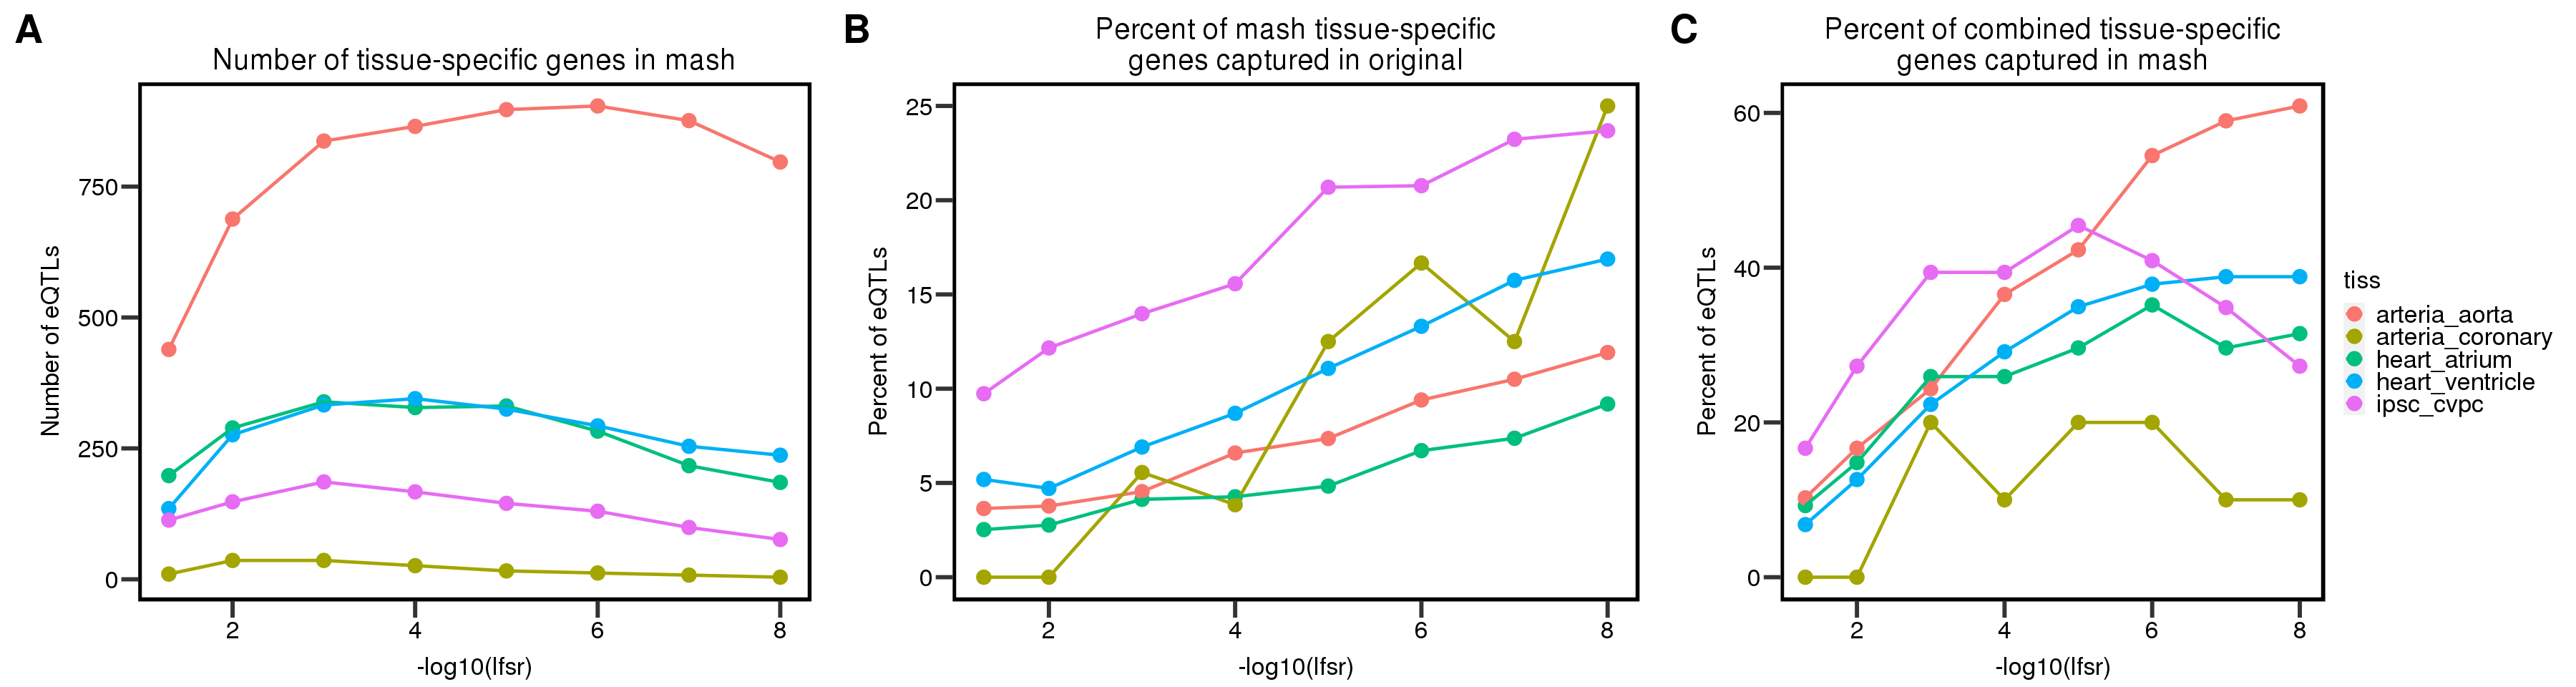

In [73]:
pvals = c(0.05, 0.01, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-15, 1e-20)
pvals = pvals[1:8]

tests.specific = as.data.frame(rbindlist(lapply(pvals, function(p)
{
    as.data.frame(rbindlist(lapply(tissues, function(tiss)
    {
        # Get tested eqtls
        tested_genes = rownames(tomash$Bhat)
        
        # Get mash specific eqtls
        mash_genes = get_specific_results(m_eqtl, tiss, p)
        
        # Get inter specific eqtls
        if (tiss == "ipscore") { tiss = "ipsc_cvpc" }
        inter_genes = unique(inter2[inter2$qtl_id %in% tested_genes & inter2$specific == T & inter2$interaction == tiss & inter2$type == 0,]$qtl_id)
        
        # Get mash only genes
        mash_only = setdiff(mash_genes, inter_genes)
        
        # Get inter only genes
        inter_only = setdiff(inter_genes, mash_genes)
        
        # Get both
        both = intersect(mash_genes, inter_genes)
        
        # Out
        data.frame(lfsr = p, 
                   tiss = tiss, 
                   ntested = length(tested_genes), 
                   nmash = length(mash_genes), 
                   ninter = length(inter_genes), 
                   mash_only = length(mash_only), 
                   inter_only = length(inter_only), 
                   both = length(both),
                   pct_mash_overlap = length(both) / length(mash_genes),
                   pct_inter_overlap = length(both) / length(inter_genes))
        
    })))
})))

# tests.specific

p0 = ggplot(tests.specific, aes(x = -log10(lfsr), y = nmash, color = tiss)) +
    geom_point(size = 5) + geom_line(size = 1) + jn_theme + theme(plot.title = element_text(hjust = 0.5), legend.position = "none") + 
    ggtitle("\nNumber of tissue-specific genes in mash") + ylab("Number of eQTLs")

p1 = ggplot(tests.specific, aes(x = -log10(lfsr), y = pct_mash_overlap * 100, color = tiss)) + 
    geom_point(size = 5) + geom_line(size = 1) + jn_theme + theme(plot.title = element_text(hjust = 0.5), legend.position = "none") + 
    ggtitle("Percent of mash tissue-specific\ngenes captured in original") + ylab("Percent of eQTLs")

p2 = ggplot(tests.specific, aes(x = -log10(lfsr), y = pct_inter_overlap * 100, color = tiss)) + 
    geom_point(size = 5) + geom_line(size = 1) + jn_theme + theme(plot.title = element_text(hjust = 0.5)) + 
    ggtitle("Percent of combined tissue-specific\ngenes captured in mash") + ylab("Percent of eQTLs")

psize(w = 30, h = 8)
plot_grid(p0, p1, p2, nrow = 1, labels = "AUTO", label_size = 33, rel_widths = c(0.9, 0.9, 1))


# Overlap with context-associated eQTLs

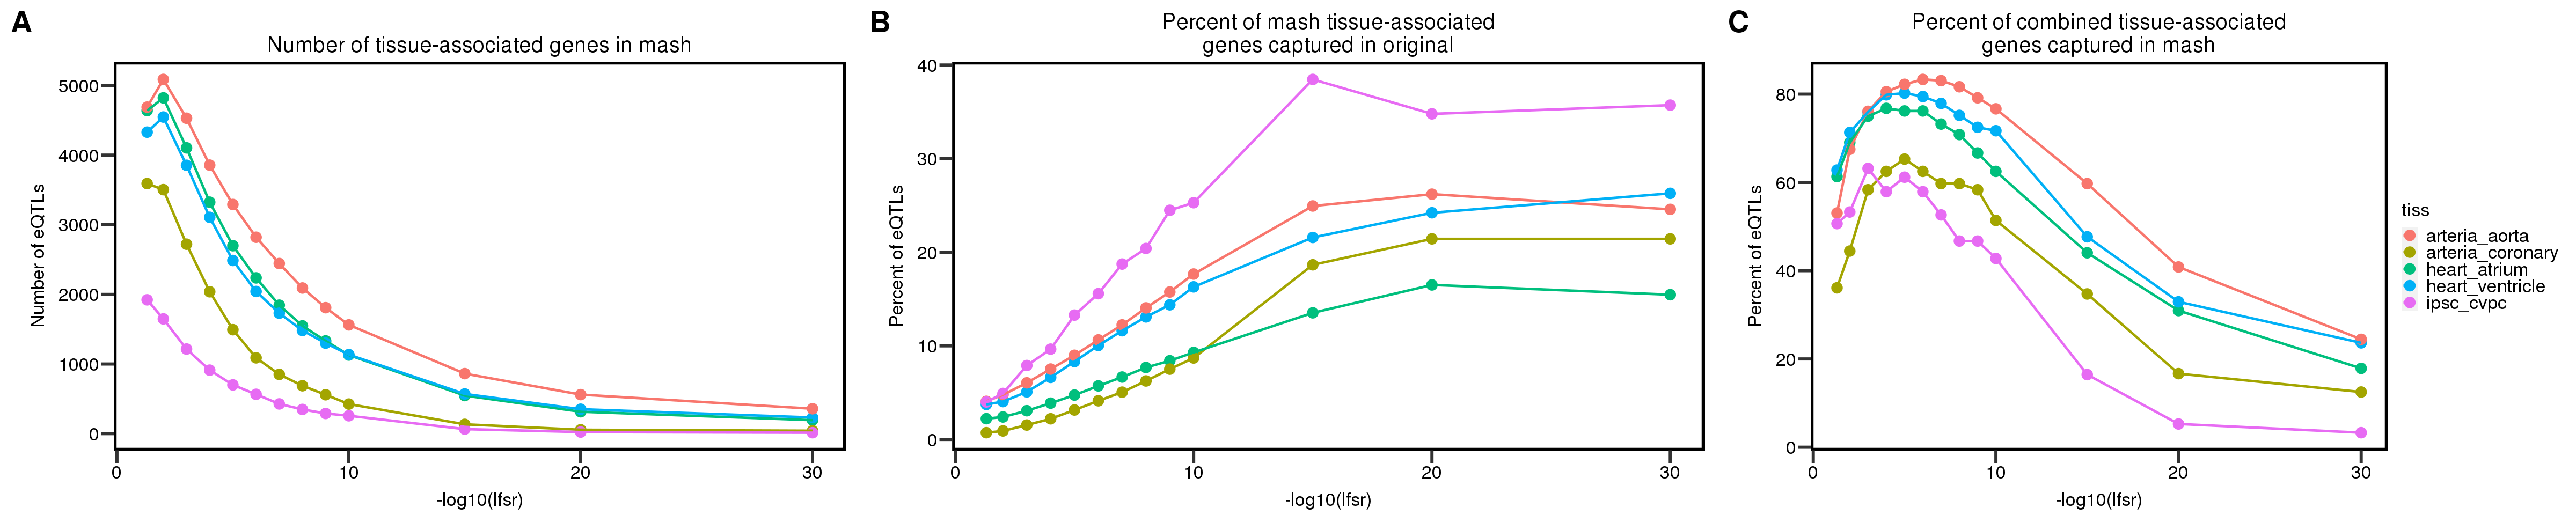

In [74]:
pvals = c(0.05, 0.01, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-15, 1e-20, 1e-30)

tests.specific = as.data.frame(rbindlist(lapply(pvals, function(p)
{
    as.data.frame(rbindlist(lapply(tissues, function(tiss)
    {
        # Get tested eqtls
        tested_genes = rownames(tomash$Bhat)
        
        # Get mash specific eqtls
        mash_genes = names(get_significant_results(m_eqtl, thresh = p, condition = tiss))
        
        # Remove eQTLs that are shared across all tissues
        n_significant_cond = data.frame(get_n_significant_conditions(m_eqtl, thresh = p))
        colnames(n_significant_cond) = c("fq")
        specific_qtls = n_significant_cond %>% filter(fq != 5)
        mash_genes = mash_genes[which(mash_genes %in% rownames(specific_qtls))]
        
        # Get inter specific eqtls
        if (tiss == "ipscore") { tiss = "ipsc_cvpc" }
        inter_genes = inter2[inter2$qtl_id %in% tested_genes & inter2$cell == T & inter2$interaction == tiss & inter2$type == 0,]$qtl_id
        
        # Get mash only genes
        mash_only = setdiff(mash_genes, inter_genes)
        
        # Get inter only genes
        inter_only = setdiff(inter_genes, mash_genes)
        
        # Get both
        both = intersect(mash_genes, inter_genes)
        
        # Out
        data.frame(lfsr = p, 
                   tiss = tiss, 
                   ntested = length(tested_genes), 
                   nmash = length(mash_genes), 
                   ninter = length(inter_genes), 
                   mash_only = length(mash_only), 
                   inter_only = length(inter_only), 
                   both = length(both),
                   pct_mash_overlap = length(both) / length(mash_genes),
                   pct_inter_overlap = length(both) / length(inter_genes))
        
    })))
})))

# tests.specific

p0 = ggplot(tests.specific, aes(x = -log10(lfsr), y = nmash, color = tiss)) +
    geom_point(size = 5) + geom_line(size = 1) + jn_theme + theme(plot.title = element_text(hjust = 0.5), legend.position = "none") + 
    ggtitle("\nNumber of tissue-associated genes in mash") + ylab("Number of eQTLs")

p1 = ggplot(tests.specific, aes(x = -log10(lfsr), y = pct_mash_overlap * 100, color = tiss)) + 
    geom_point(size = 5) + geom_line(size = 1) + jn_theme + theme(plot.title = element_text(hjust = 0.5), legend.position = "none") + 
    ggtitle("Percent of mash tissue-associated\ngenes captured in original") + ylab("Percent of eQTLs")

p2 = ggplot(tests.specific, aes(x = -log10(lfsr), y = pct_inter_overlap * 100, color = tiss)) + 
    geom_point(size = 5) + geom_line(size = 1) + jn_theme + theme(plot.title = element_text(hjust = 0.5)) + 
    ggtitle("Percent of combined tissue-associated\ngenes captured in mash") + ylab("Percent of eQTLs")

p3 = ggplot(tests.specific, aes(x = -log10(lfsr), y = both, color = tiss)) + 
    geom_point(size = 5) + geom_line(size = 1) + jn_theme + theme(plot.title = element_text(hjust = 0.5)) + 
    ggtitle("Number of Overlapping eQTLs") + ylab("Number of Overlapping QTLs")

psize(w = 40, h = 8)
plot_grid(p0, p1, p2, nrow = 1, labels = "AUTO", label_size = 33, rel_widths = c(0.9, 0.9, 0.9, 1))


# Plotting functions

In [75]:
library(VennDiagram)

display_venn <- function(x, title, ...){
  library(VennDiagram)
  grid.newpage()
  venn_object <- venn.diagram(x, sub.cex = 5, filename = NULL, main = title, cat.cex = 2, label.cex = 2, cex = 2, main.cex = 3, ...)
  grid.draw(venn_object)
}

In [76]:
plot_example = function(qtl_id)
{
    gene_id = unlist(strsplit(qtl_id, " "))[1]
    snp = unlist(strsplit(qtl_id, " "))[2]

    mlist = list()

    mlist[[1]] = suppressMessages(plot_grid(plotlist = lapply(tissues, function(tiss)
    {
        message(tiss)
        my_box(gene_id, snp, tiss, 0, tomash$Bhat[qtl_id,tiss], tomash$Shat[qtl_id, tiss])
    }), nrow = 1))

    mlist[[2]] = suppressMessages(plot_grid(plotlist = lapply(tissues, function(tiss)
    {
        lfsr_value = unique(lfsr[lfsr$qtl_id == qtl_id, tiss])
        
        if (tiss == "ipscore") { tiss = "ipsc_cvpc" }
        beta_0 = inter2[inter2$qtl_id == qtl_id & inter2$interaction == tiss,]$beta_0
        beta_1 = inter2[inter2$qtl_id == qtl_id & inter2$interaction == tiss,]$beta_1
        qval_0 = inter2[inter2$qtl_id == qtl_id & inter2$interaction == tiss,]$qval_0
        qval_1 = inter2[inter2$qtl_id == qtl_id & inter2$interaction == tiss,]$qval_1
        qval_int = inter2[inter2$qtl_id == qtl_id & inter2$interaction == tiss,]$qval_int

        tiss_name = mapvalues(tiss, from = c("ipsc_cvpc", "heart_atrium", "heart_ventricle", "arteria_aorta", "arteria_coronary"),
                              to = c("iPSC-CVPC", "Heart_Atrium", "Heart_Ventricle", "Arteria_Aorta", "Arteria_Coronary"))

        if (tiss == "ipsc_cvpc") { beta = tomash$Bhat[qtl_id,"ipscore"] } else { beta = tomash$Bhat[qtl_id,tiss] }

        original_box(gene_id, snp, tiss, 0, qval_int, qval_0, qval_1, beta_0, beta_1, snp, gene_id, beta, tiss_name, lfsr_value)
    }), nrow = 1))

#     psize(w = 25, h = 14)
#     suppressMessages(plot_grid(plotlist = mlist, ncol = 1, rel_heights = c(0.80, 1)))
    mlist[[2]]
}

# Test different p-values

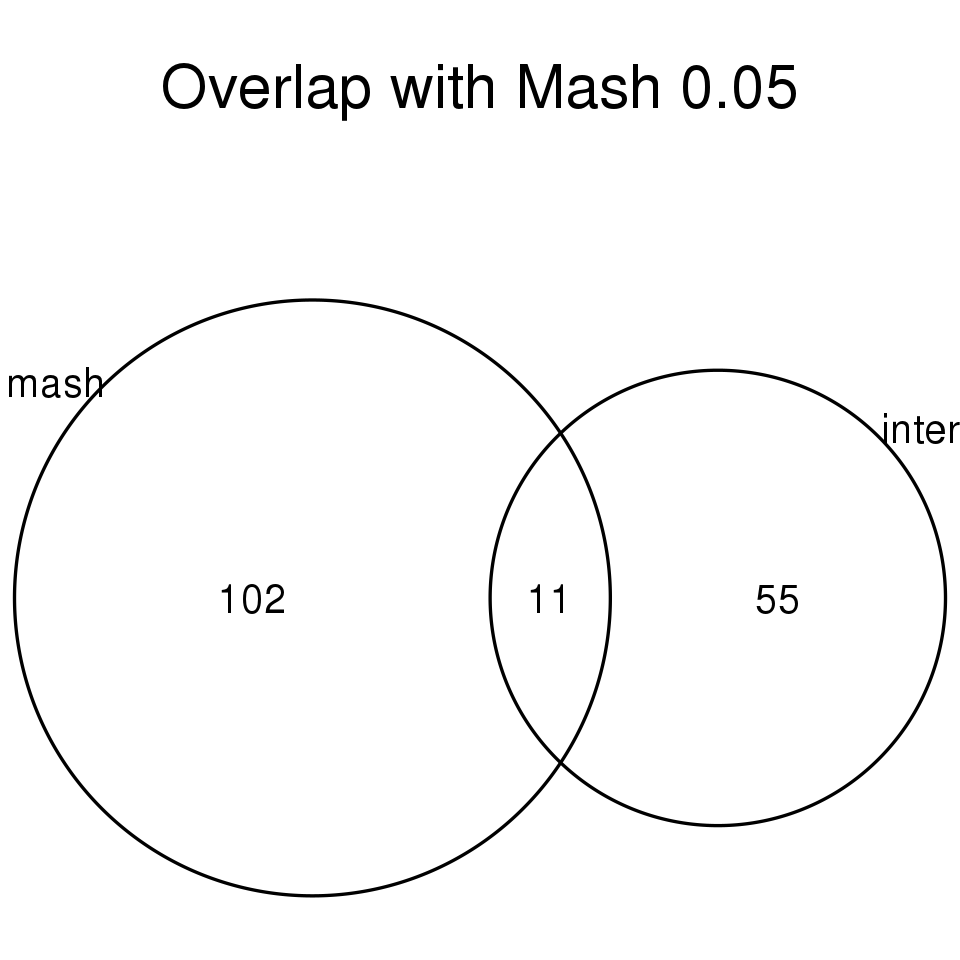

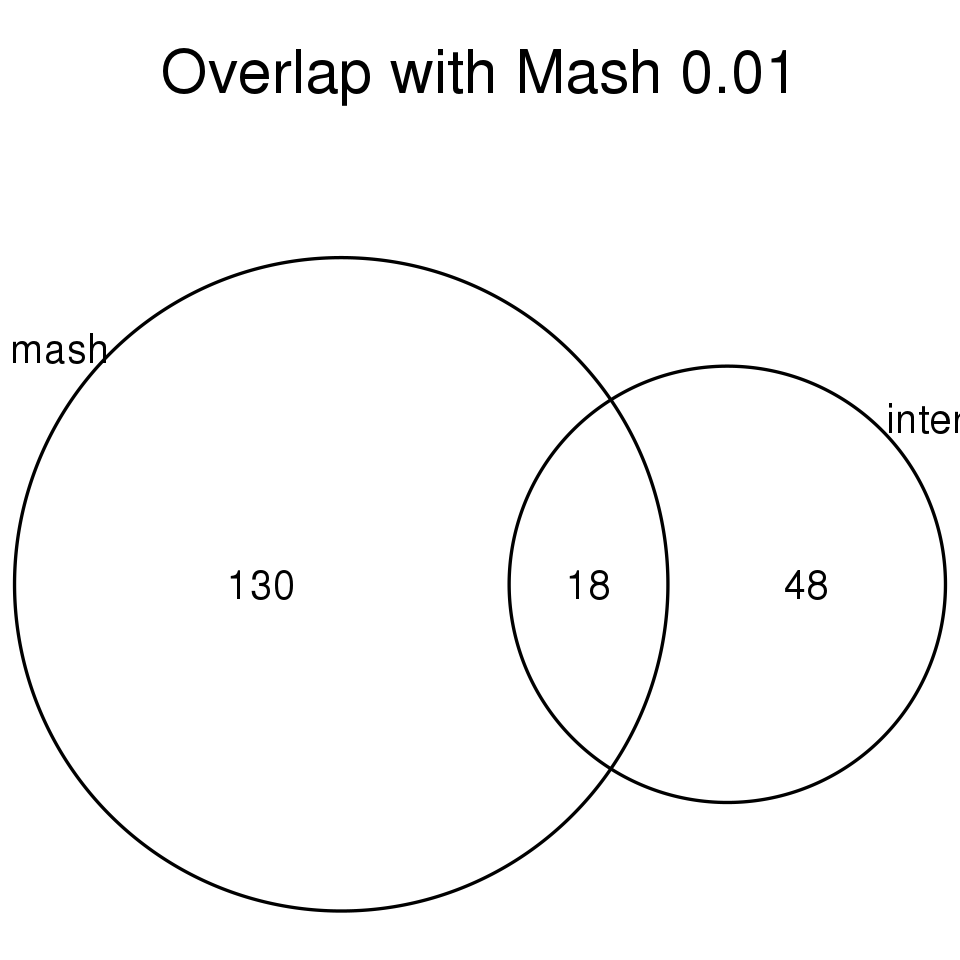

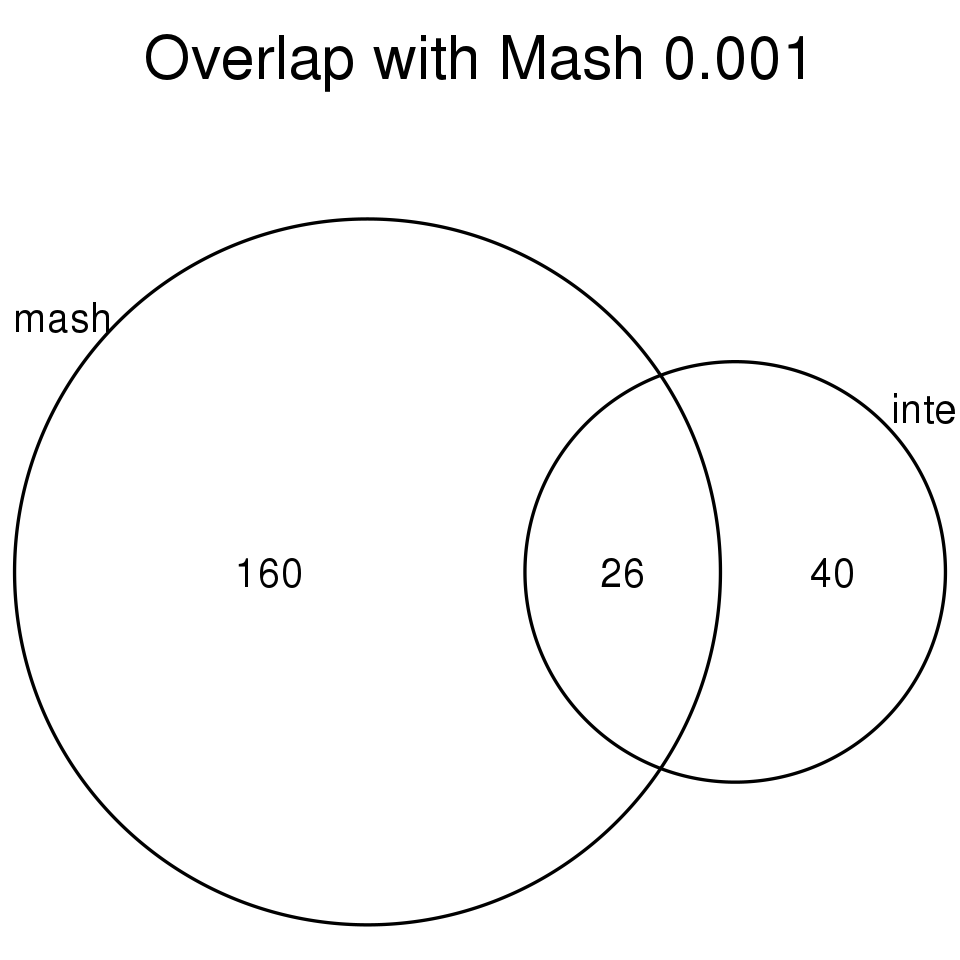

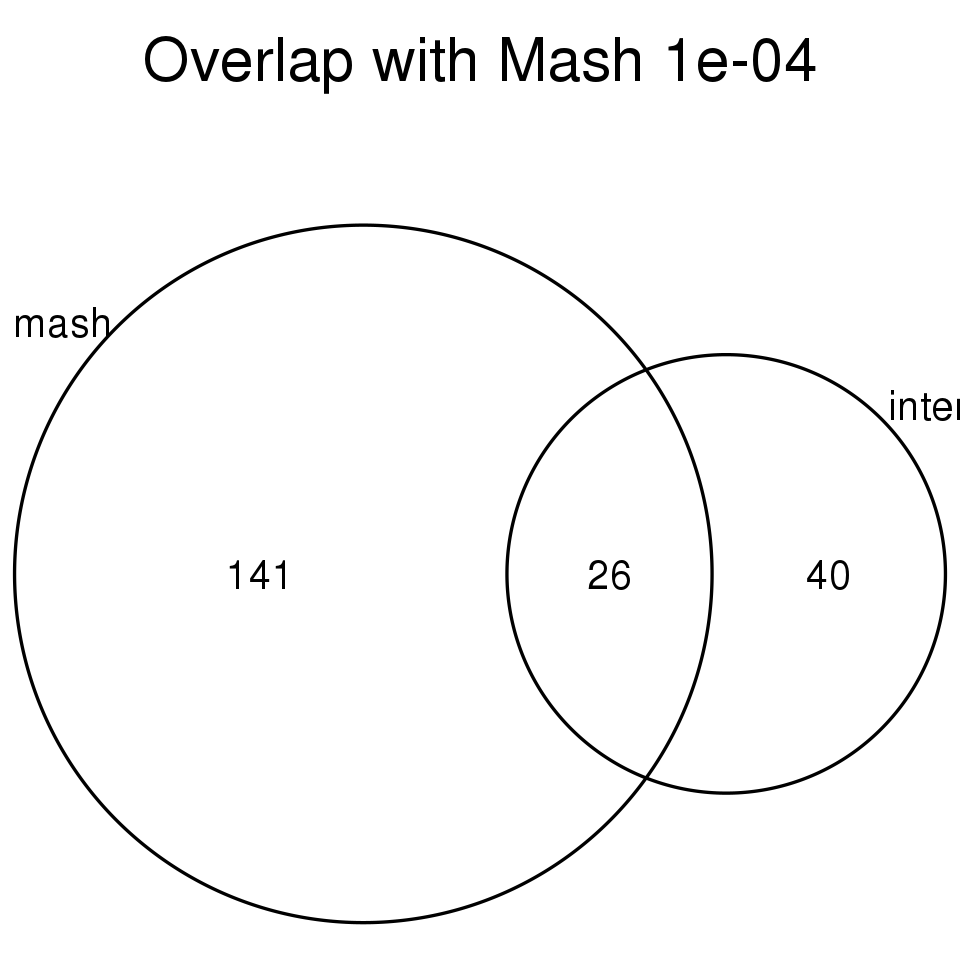

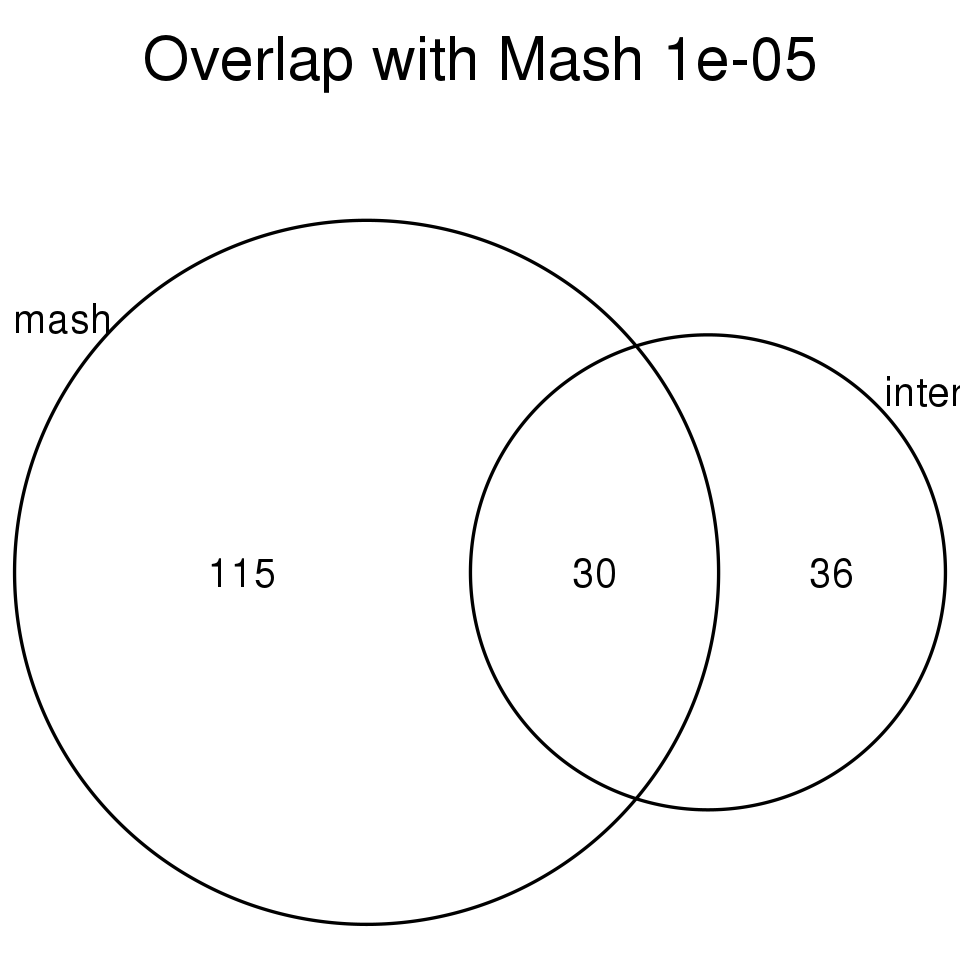

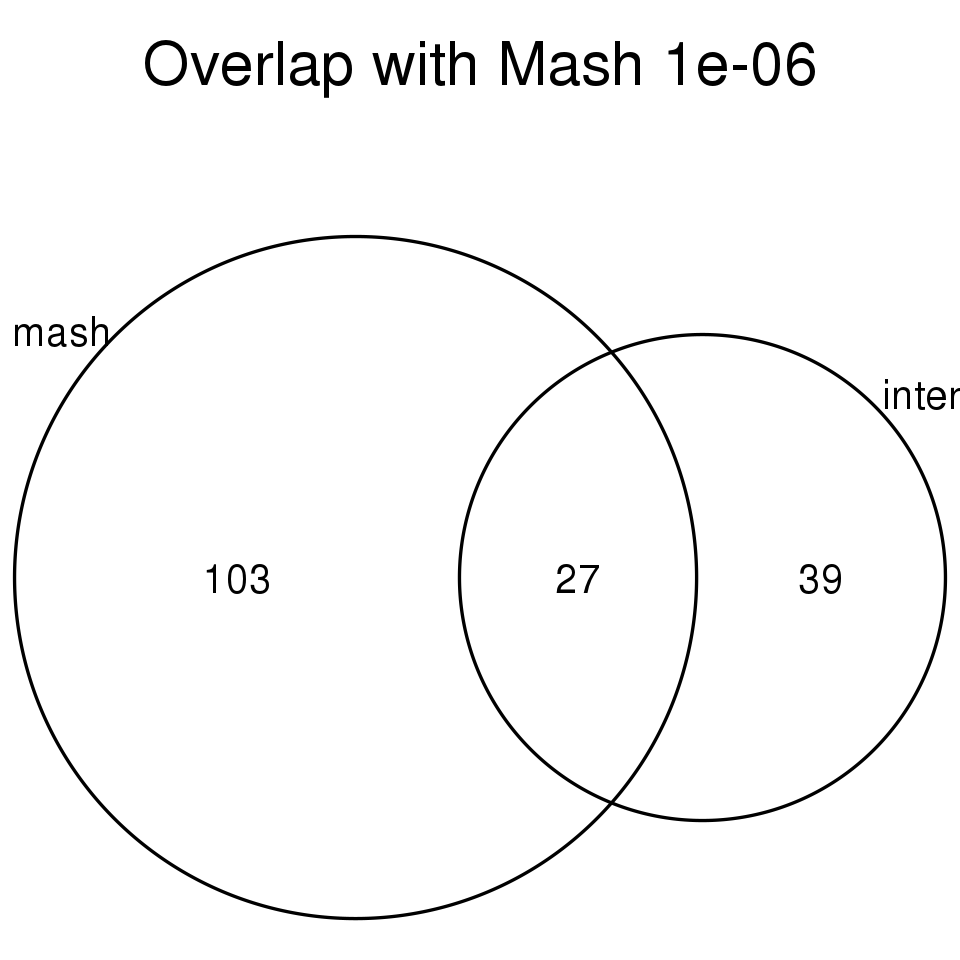

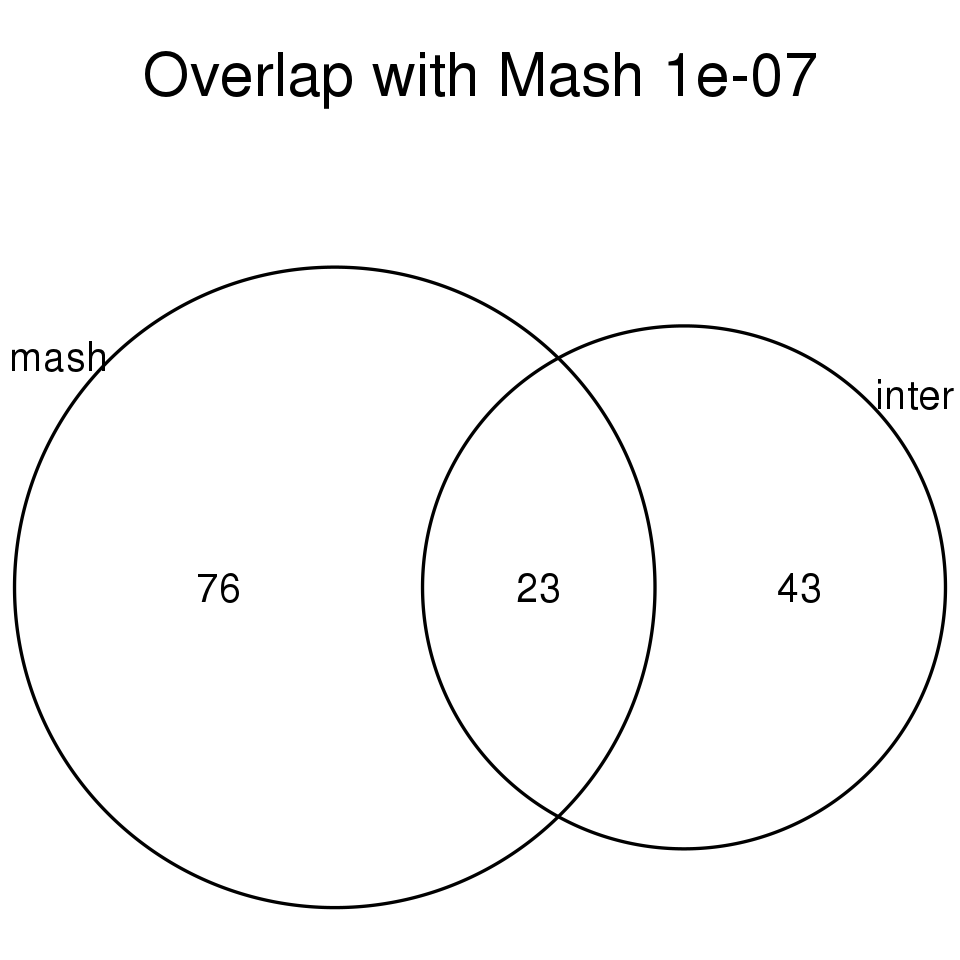

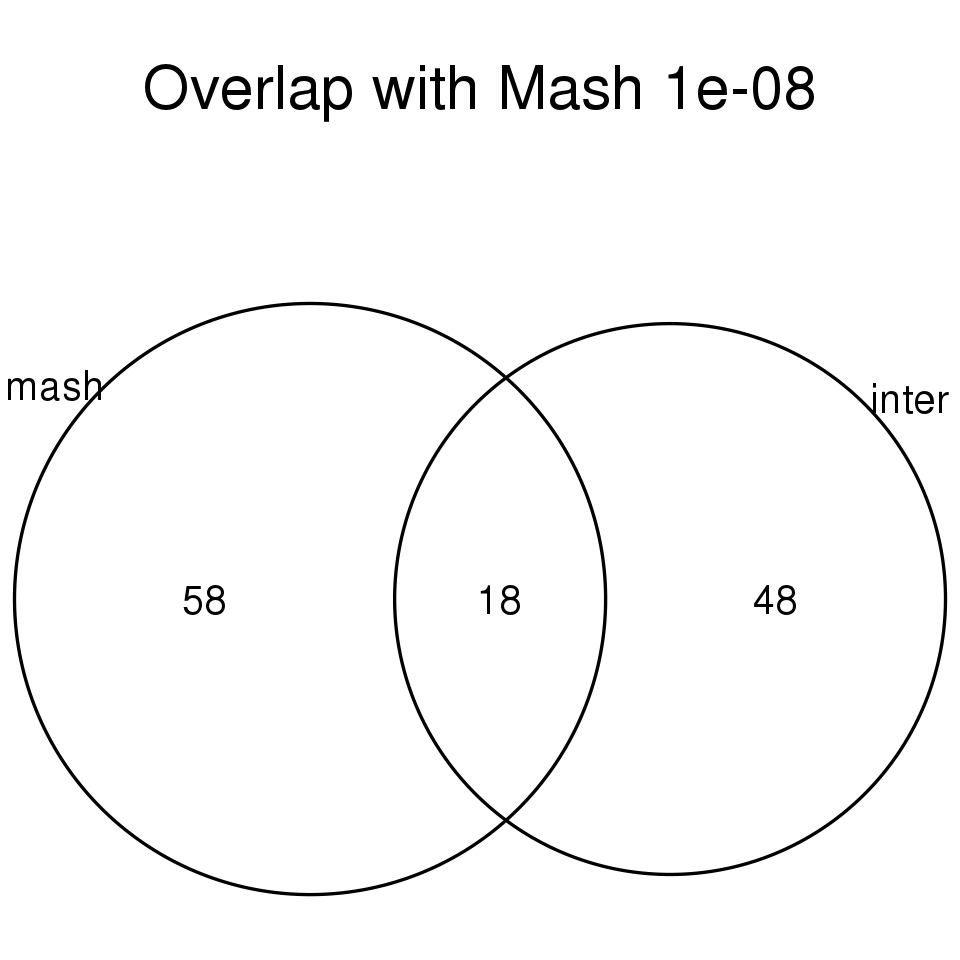

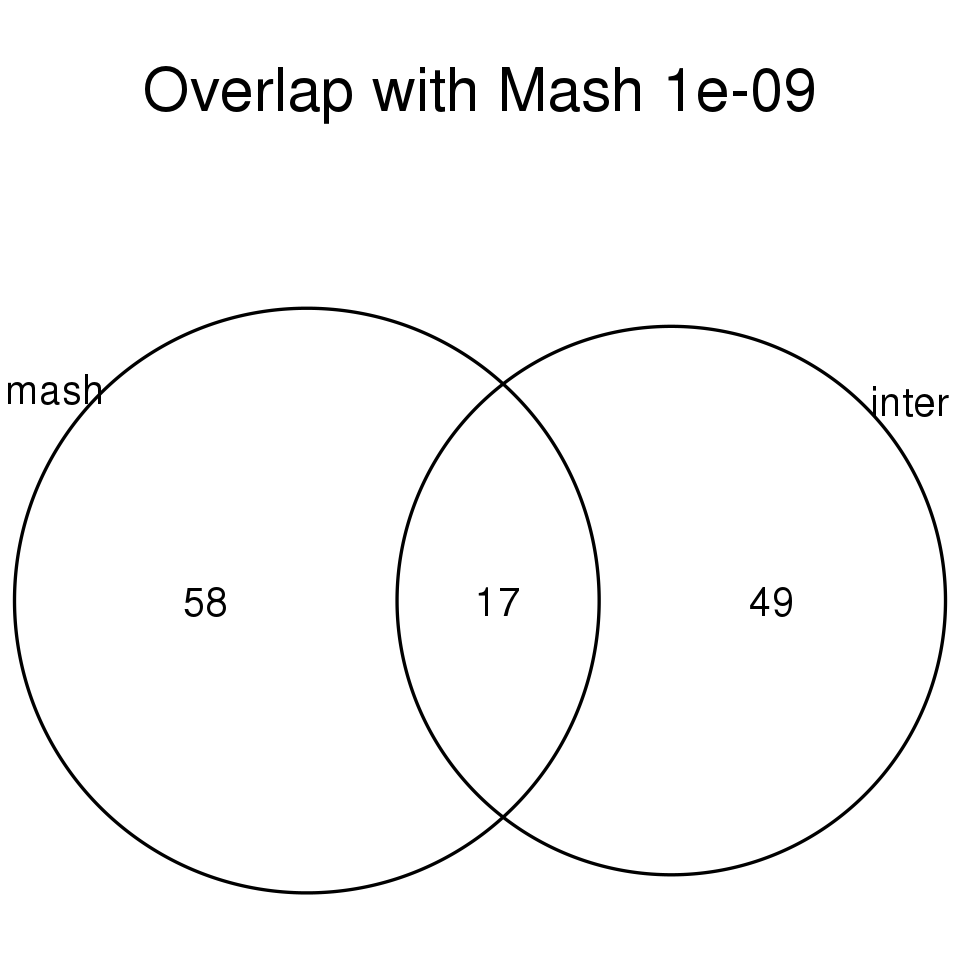

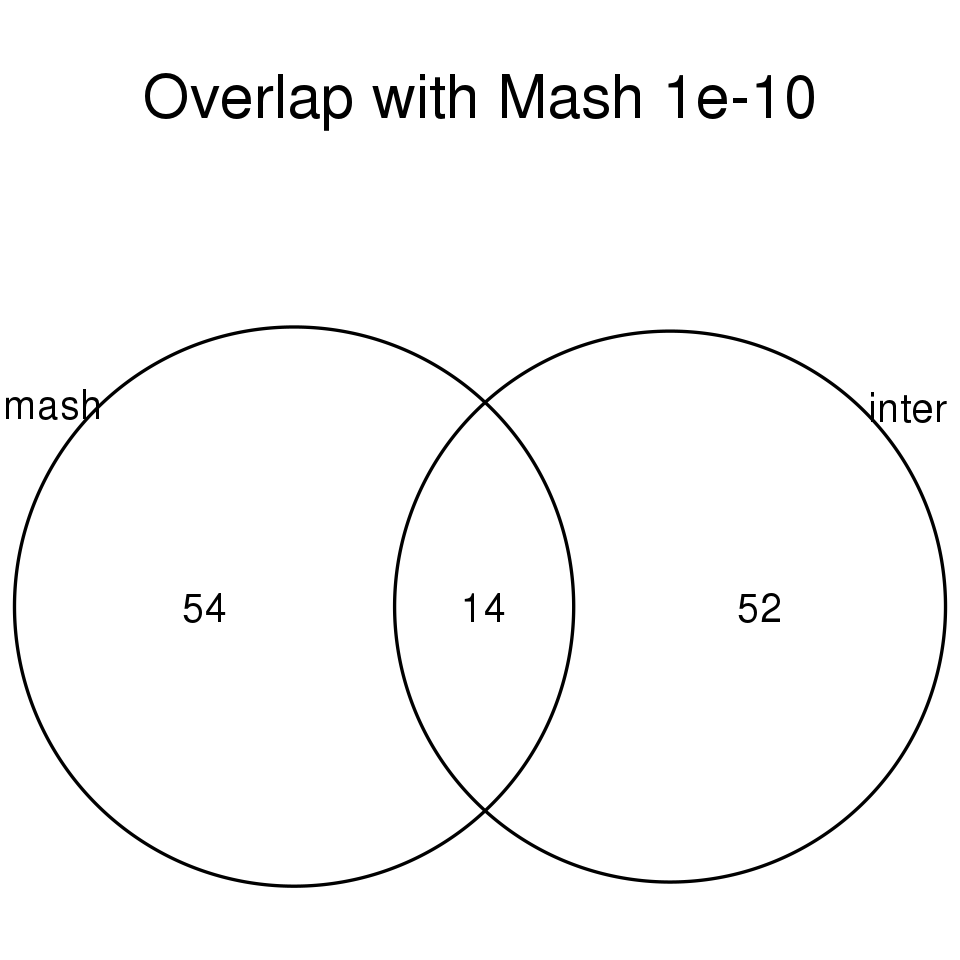

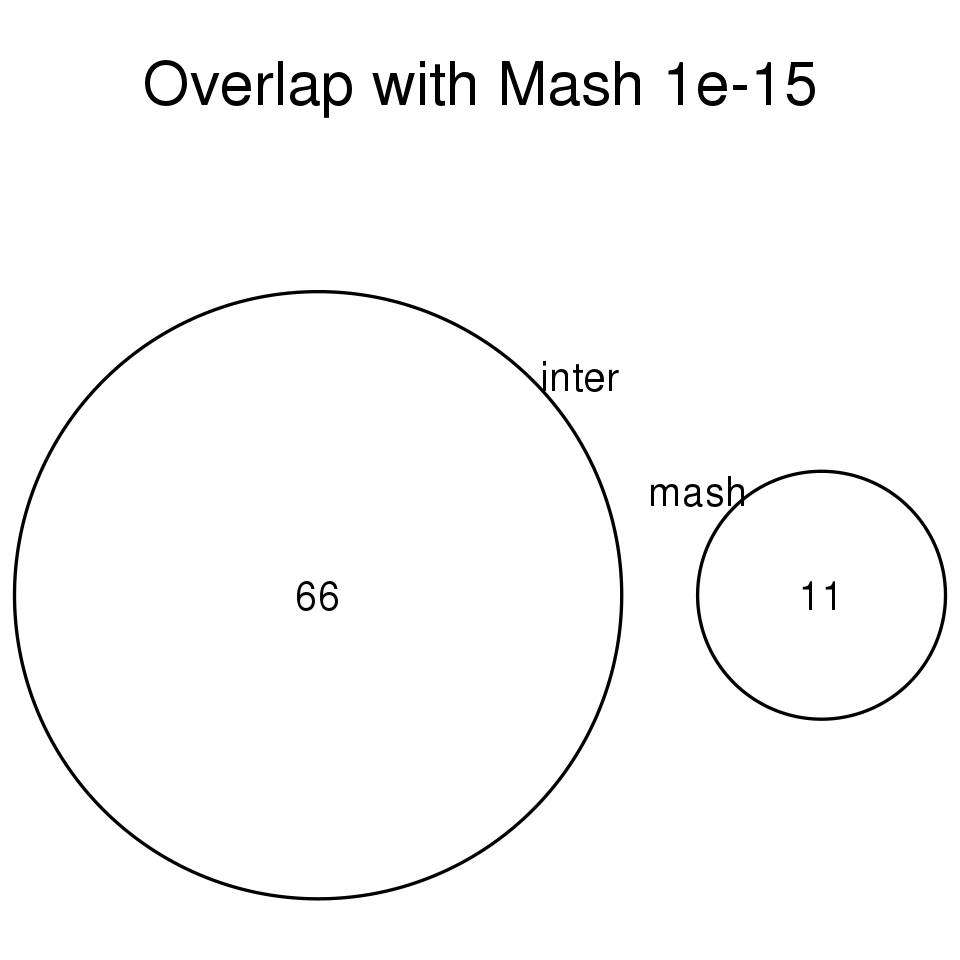

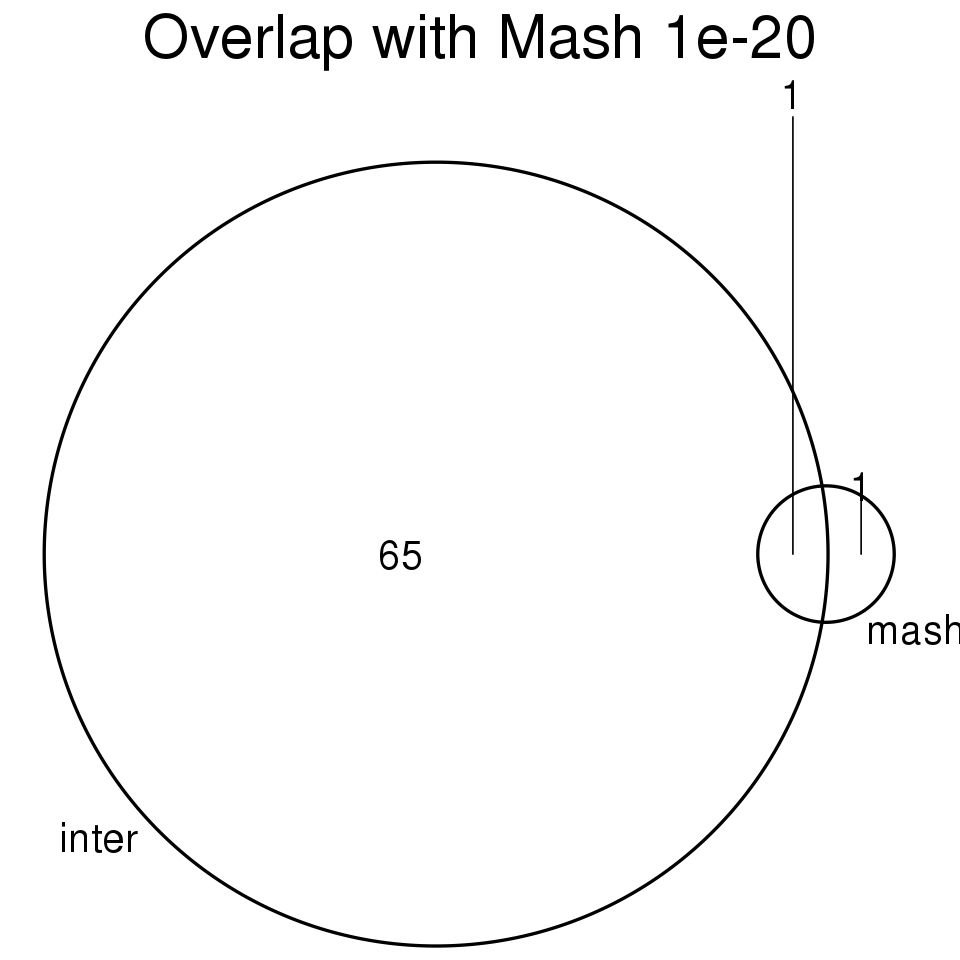

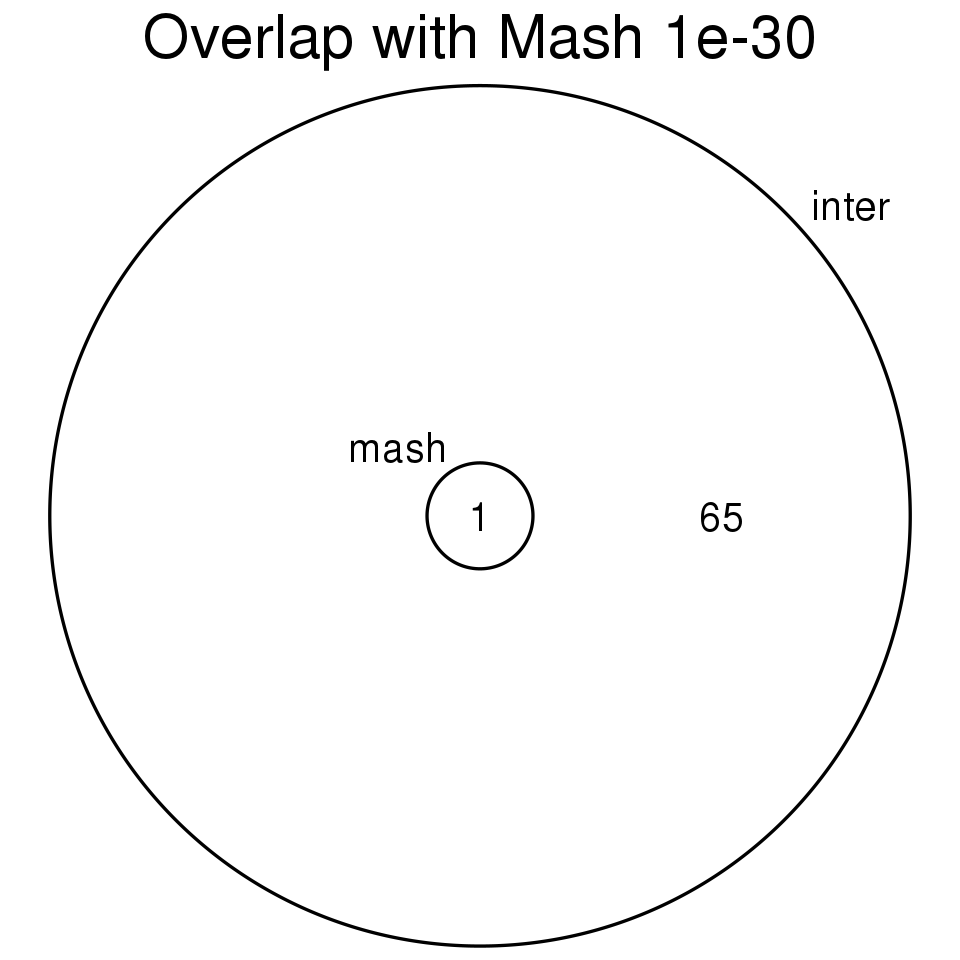

In [77]:
for (p in pvals)
{
    tiss = "ipscore"
    
    # Get tested eqtls
    tested_genes = rownames(tomash$Bhat)

    # Get mash specific eqtls
    mash_genes = get_specific_results(m_eqtl, tiss, p)

    # Get inter specific eqtls
    if (tiss == "ipscore") { tiss = "ipsc_cvpc" }
    inter_genes = inter2[inter2$qtl_id %in% tested_genes & inter2$specific == T & inter2$interaction == tiss & inter2$type == 0,]$qtl_id

    # Get mash only genes
    mash_only = setdiff(mash_genes, inter_genes)

    # Get inter only genes
    inter_only = setdiff(inter_genes, mash_genes)

    # Get both
    both = intersect(mash_genes, inter_genes)
    
    psize(w = 8, h = 8)
    x = list(mash = unique(mash_genes), inter = unique(inter_genes))
    display_venn(x, paste("Overlap with Mash", p))
}

# Test different betas

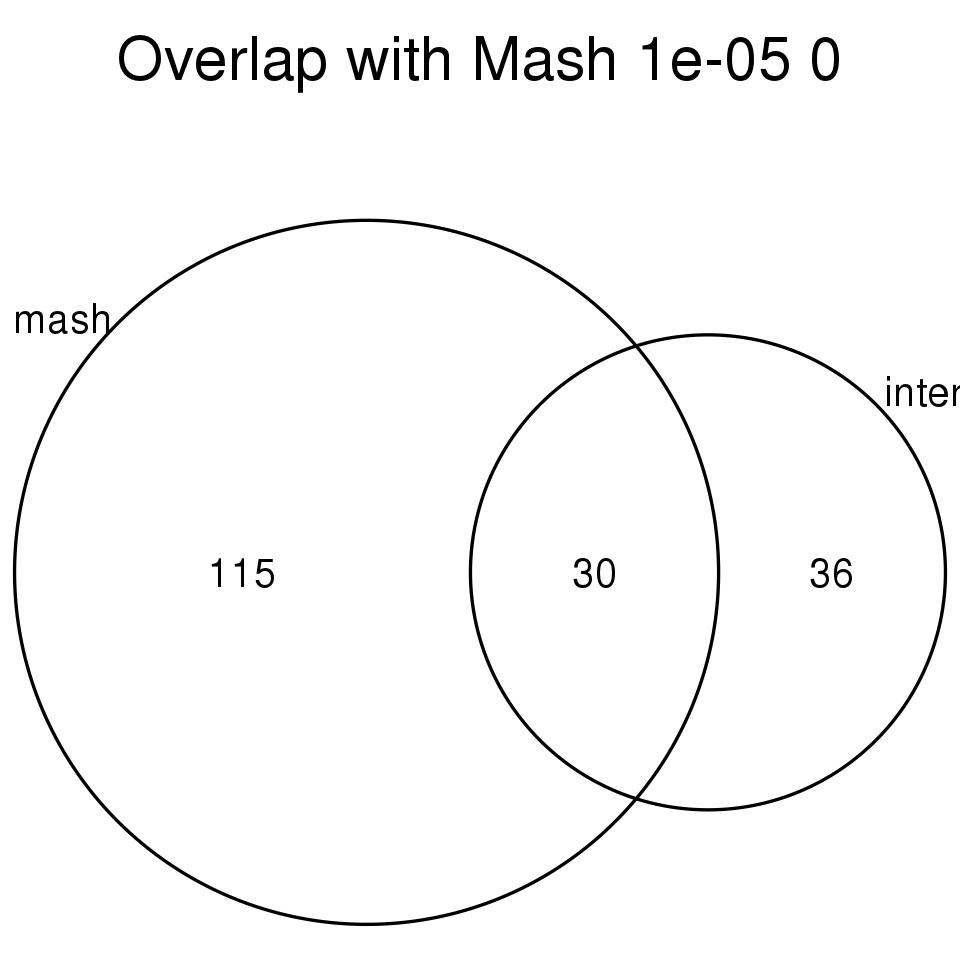

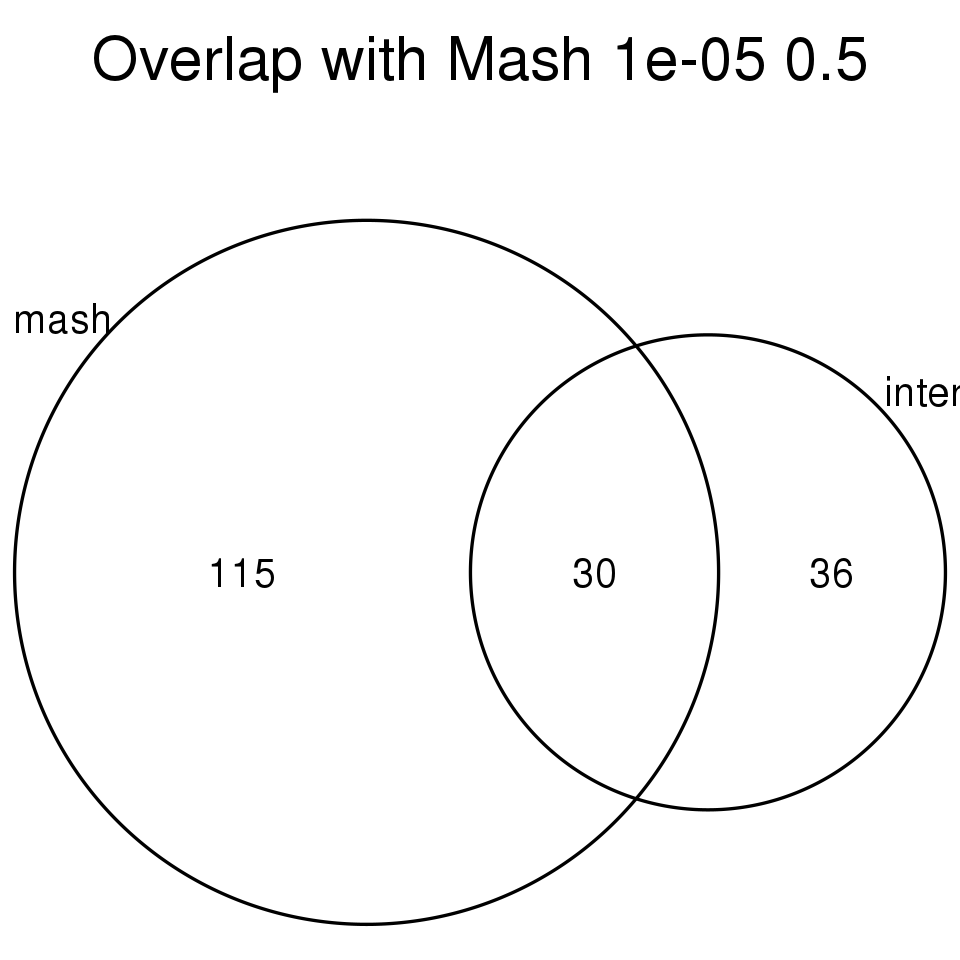

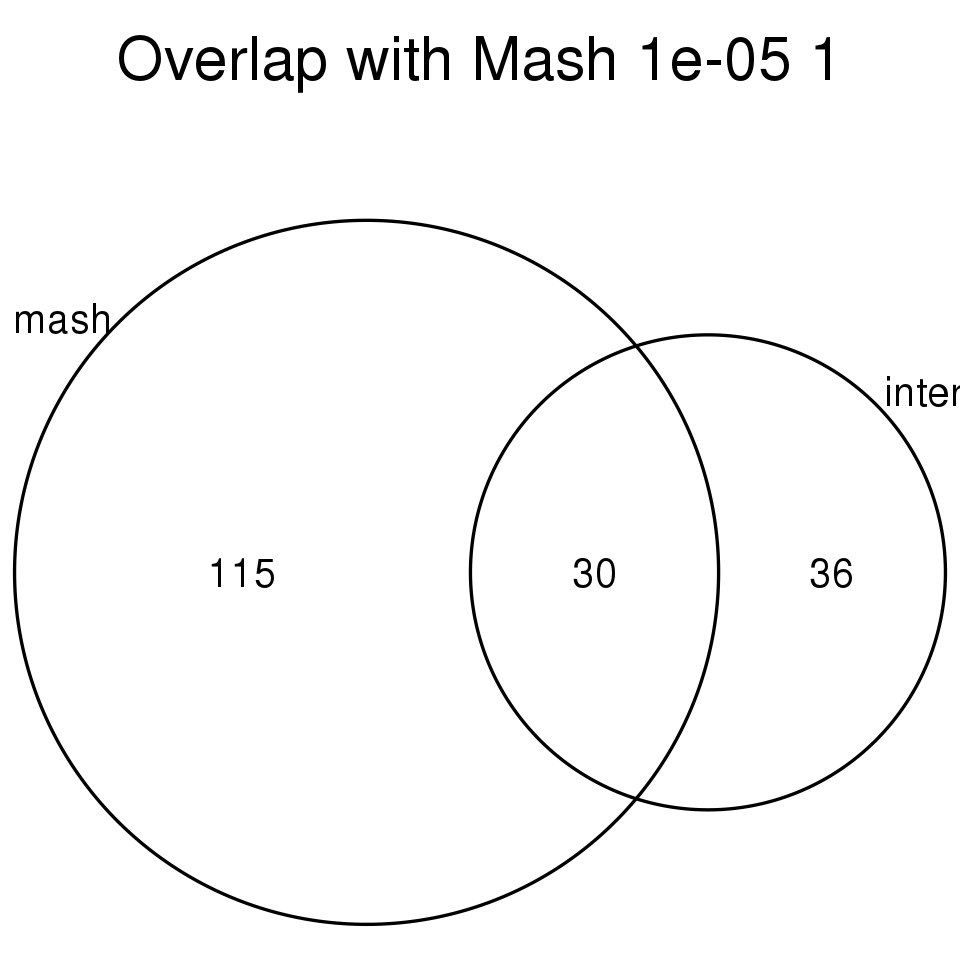

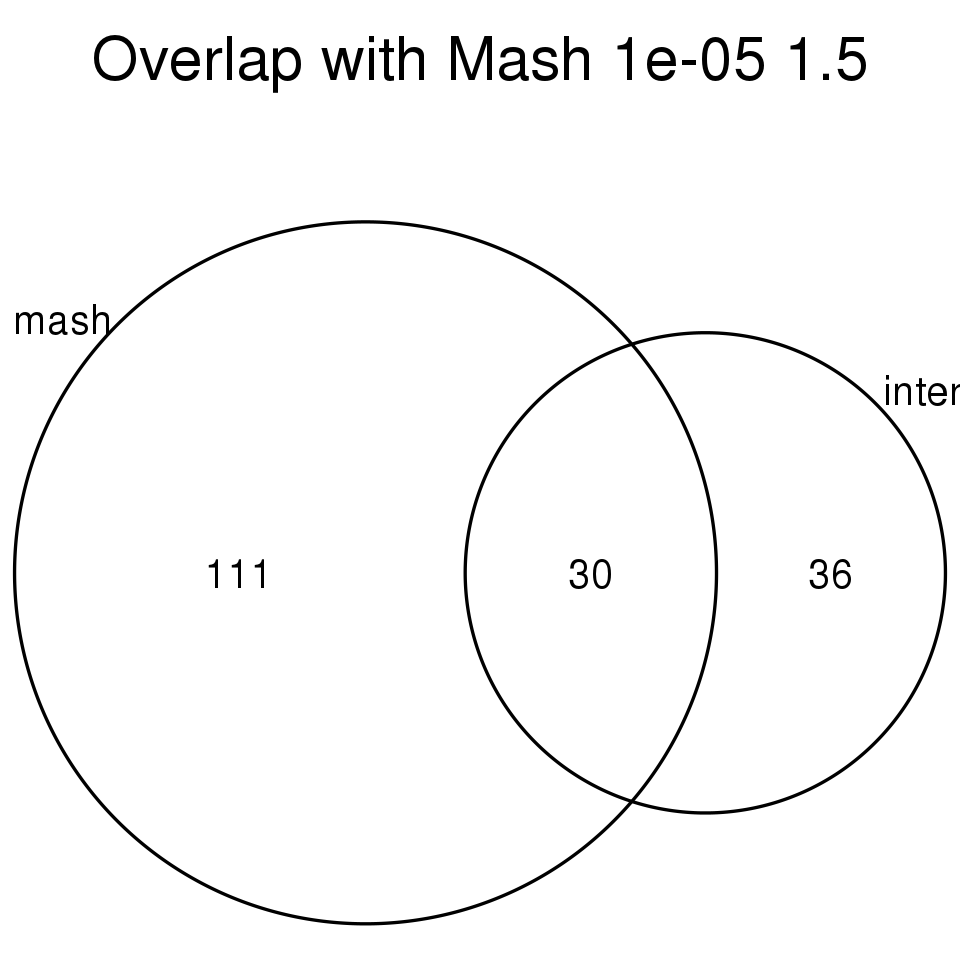

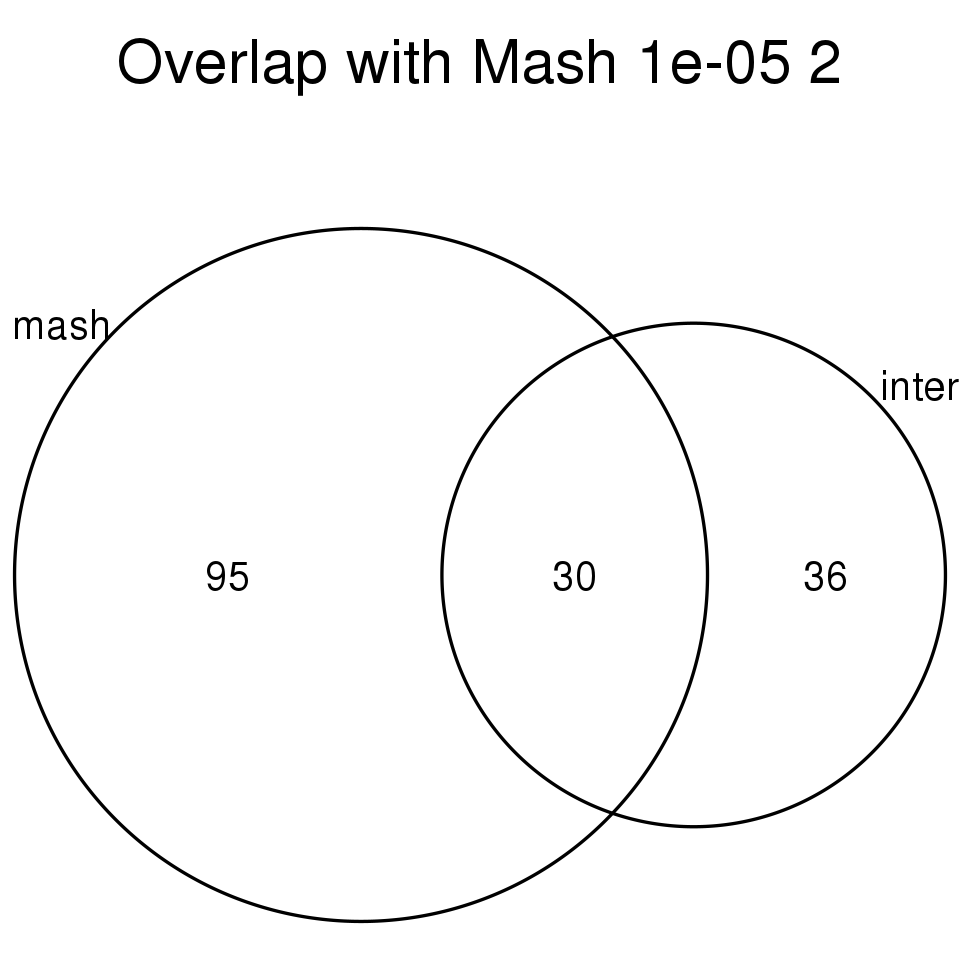

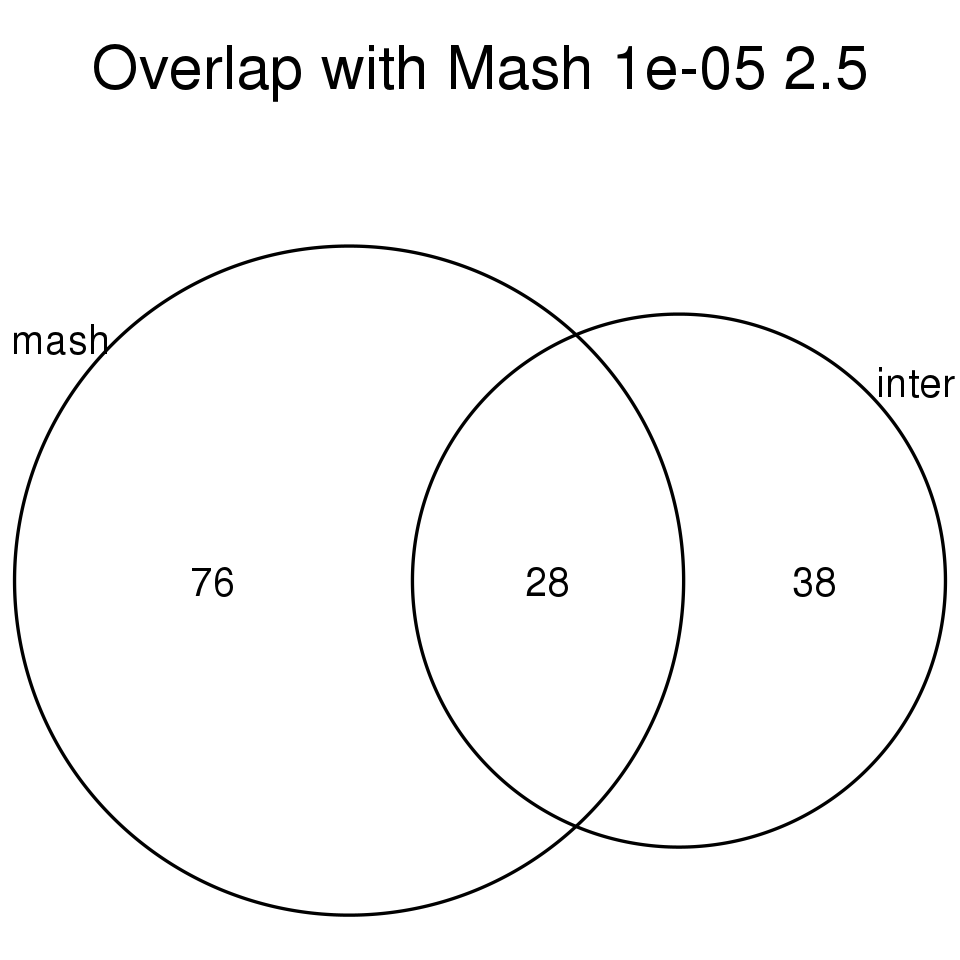

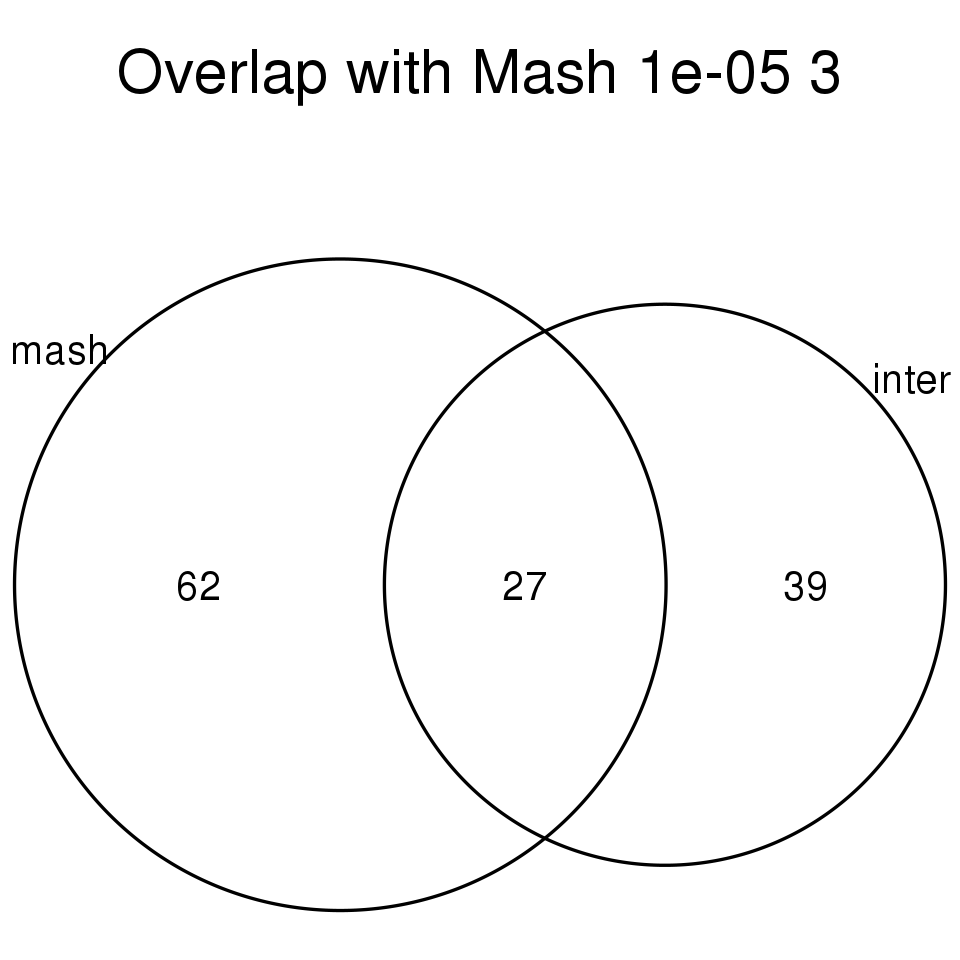

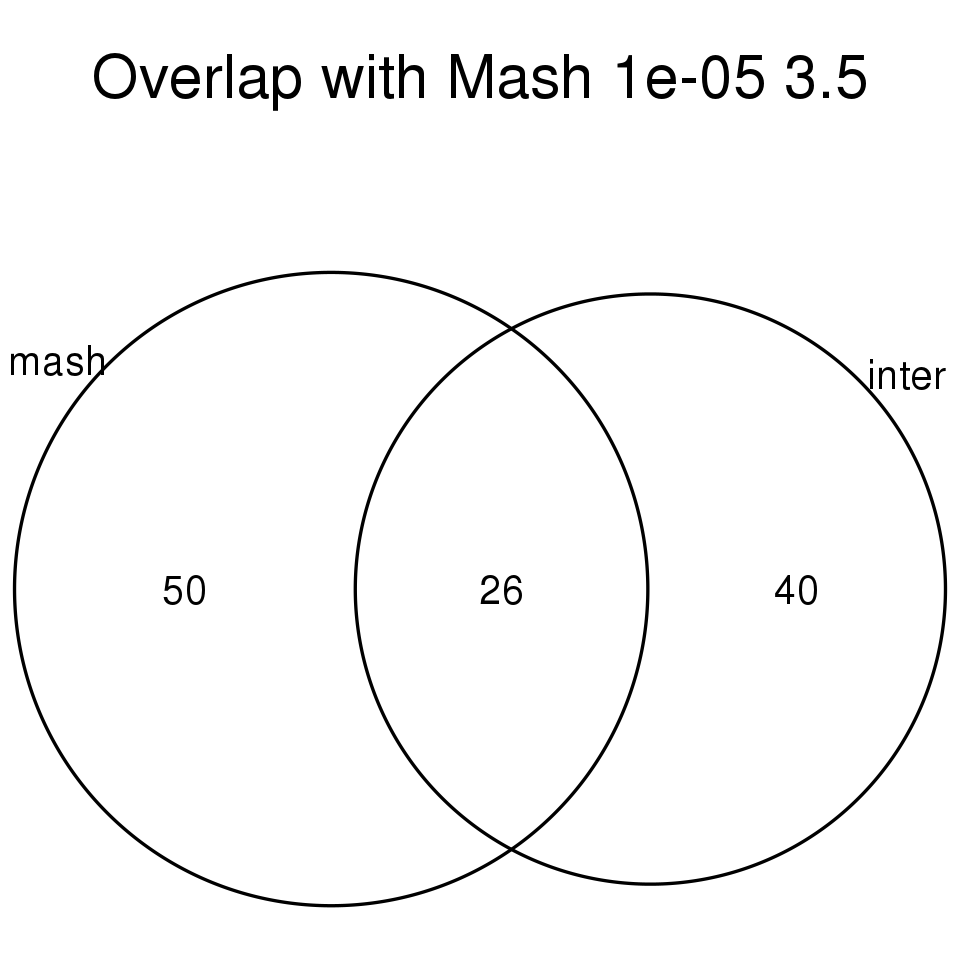

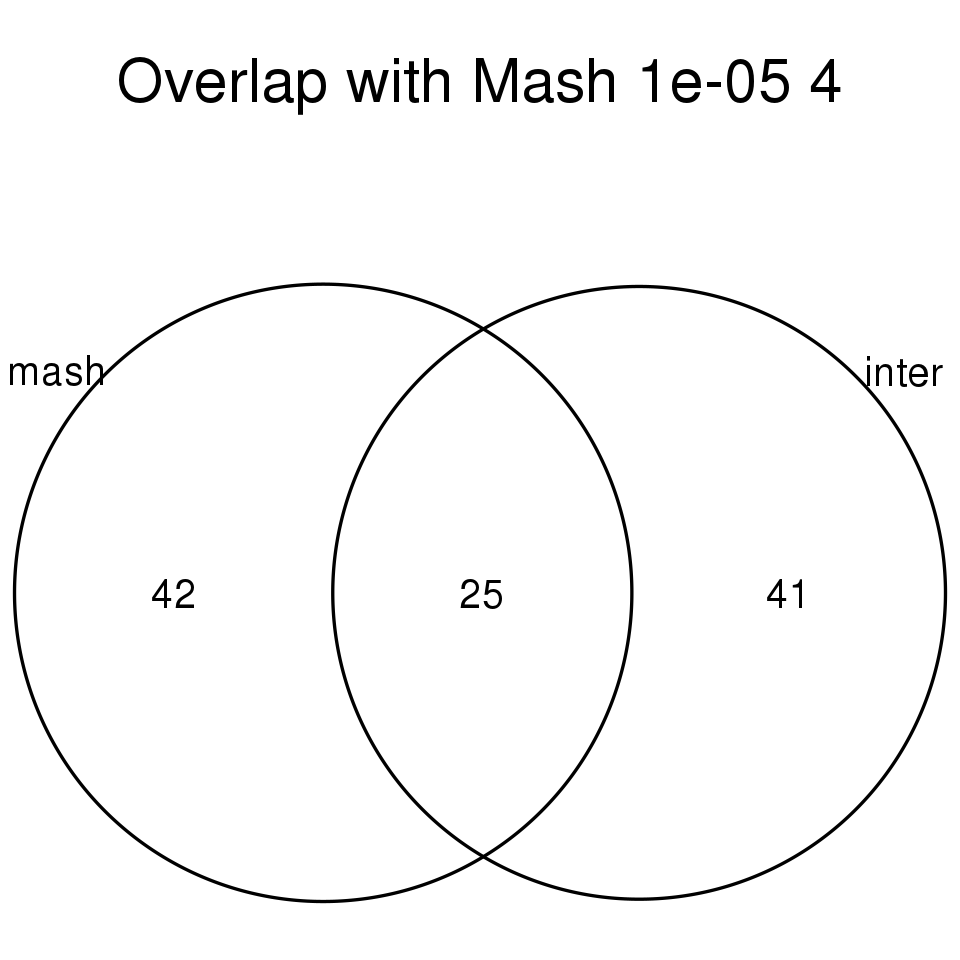

In [78]:
p = 1e-5
betas = c(0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4)

for (b in betas)
{
    tiss = "ipscore"

    # Get tested eqtls
    tested_genes = rownames(tomash$Bhat)

    # Get mash specific eqtls
    mash_genes = get_specific_results(m_eqtl, tiss, p)

    # Filter mash genes with beta fold
    compare_beta = data.frame(tomash$Bhat[mash_genes,])
    compare_beta$avg_fold = rowMeans(compare_beta[,c(1:4)]) # mean of adult
    compare_beta$beta_fold = log2(abs(compare_beta$ipscore / compare_beta$avg_fold))
    compare_beta = compare_beta[compare_beta$beta_fold >= log2(b),]
    mash_genes = unique(mash_genes[which(mash_genes %in% rownames(compare_beta))])

    # Get inter specific eqtls
    if (tiss == "ipscore") { tiss = "ipsc_cvpc" }
    inter_genes = unique(inter2[inter2$qtl_id %in% tested_genes & inter2$specific == T & inter2$interaction == tiss,]$qtl_id)

    # Get mash only genes
    mash_only = setdiff(mash_genes, inter_genes)

    # Get inter only genes
    inter_only = setdiff(inter_genes, mash_genes)

    # Get both
    both = intersect(mash_genes, inter_genes)
    
    psize(w = 8, h = 8)
    x = list(mash = unique(mash_genes), inter = unique(inter_genes))
    display_venn(x, paste("Overlap with Mash", p, b))  
}


# Plot specific examples

    - run below plotting functions first

In [79]:
p = 1e-5
b = 2
tiss = "ipscore"

post_mean = as.data.frame(get_pm(m_eqtl))
lfsr = as.data.frame(get_lfsr(m_eqtl))
lfsr$qtl_id = rownames(lfsr)

lfsr = merge(lfsr, inter2[,c("qtl_id", "interaction", "qval_int", "beta_0", "beta_1", "qval_0", "qval_1", "cell", "specific")], by = c("qtl_id"), all.x = T)

# Get tested eqtls
tested_genes = rownames(tomash$Bhat)

# Get mash specific eqtls
mash_genes = get_specific_results(m_eqtl, tiss, p)

# Filter mash genes with beta fold
compare_beta = data.frame(tomash$Bhat[mash_genes,])
compare_beta$avg_fold = rowMeans(compare_beta[,c(1:4)]) # mean of adult
compare_beta$beta_fold = log2(abs(compare_beta$ipscore / compare_beta$avg_fold))
compare_beta = compare_beta[compare_beta$beta_fold >= log2(b),]
mash_genes = unique(mash_genes[which(mash_genes %in% rownames(compare_beta))])

# Get inter specific eqtls
if (tiss == "ipscore") { tiss = "ipsc_cvpc" }
inter_genes = unique(inter2[inter2$qtl_id %in% tested_genes & inter2$specific == T & inter2$interaction == tiss & inter2$type == 0,]$qtl_id)

# Get mash only genes
mash_only = setdiff(mash_genes, inter_genes)

# Get inter only genes
inter_only = setdiff(inter_genes, mash_genes)

# Get both
both = intersect(mash_genes, inter_genes)

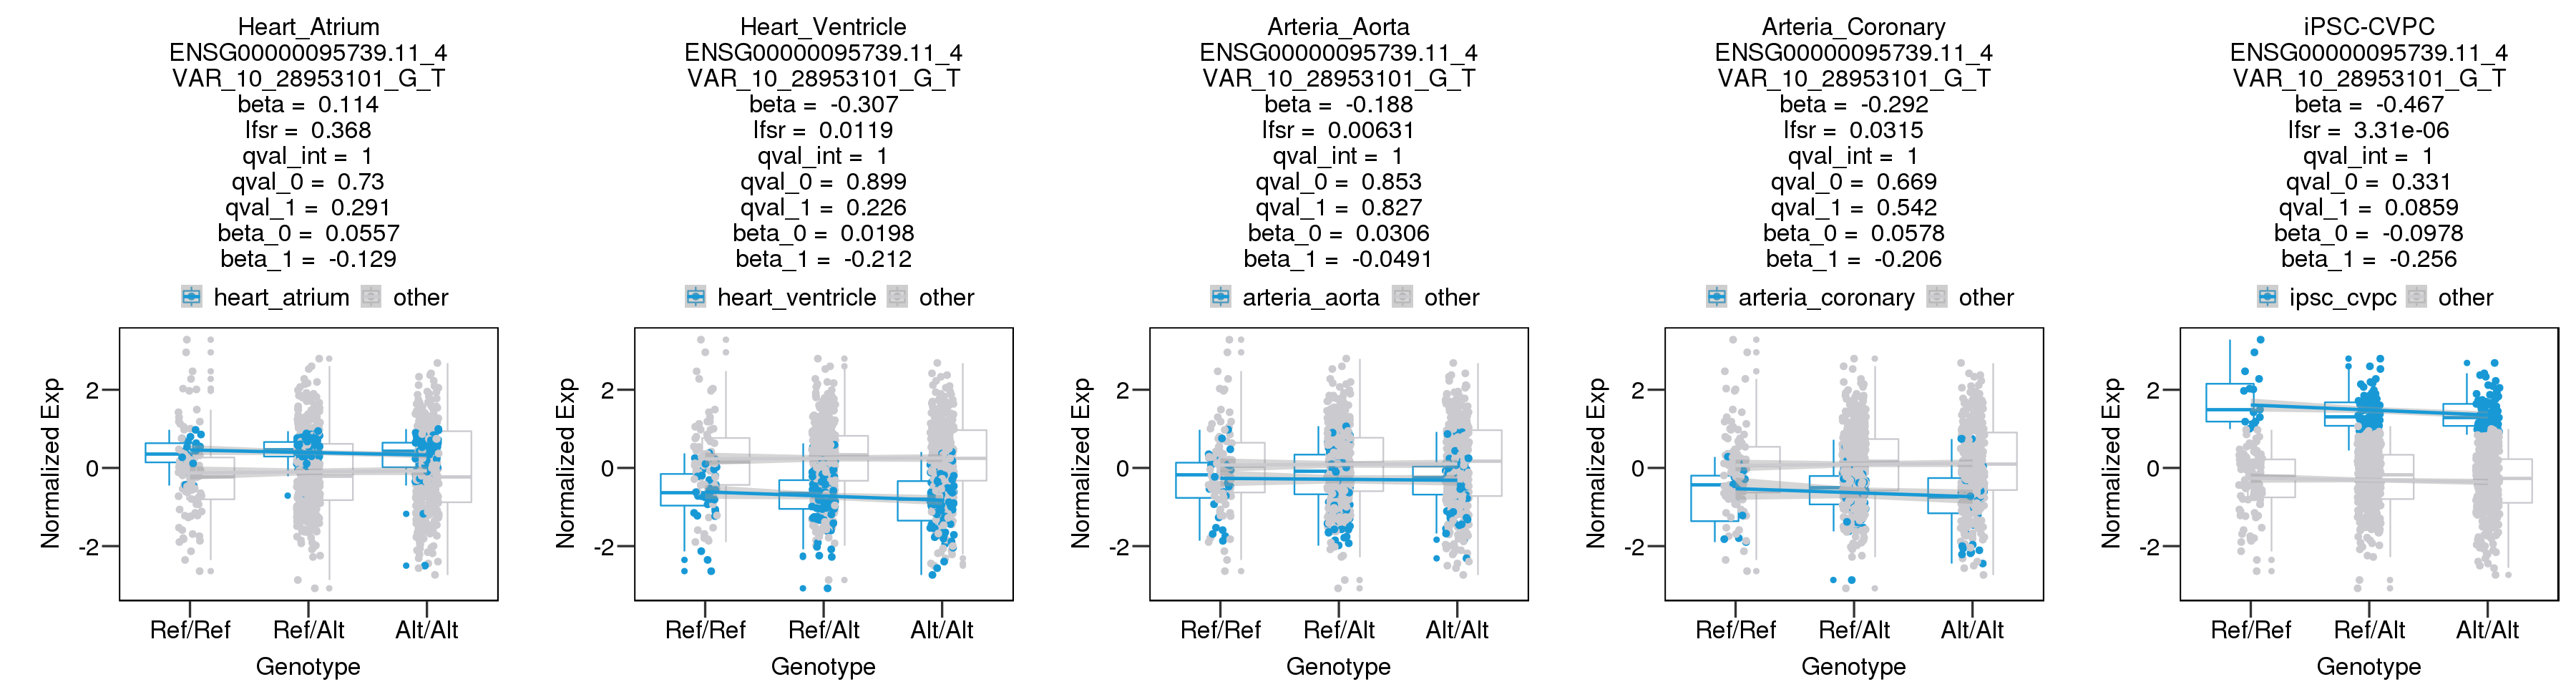

In [67]:
psize(w = 30, h = 8)
plot_example(mash_only[8])


# More plotting functions

In [50]:
my_box = function(gene_id, snp, tissue, qtl_type, beta, se)
{
    meta_wgs = fread("pipeline/1.1.metadata/meta_wgs.txt", data.table = F)
    meta_rna = fread("pipeline/1.1.metadata/meta_rna.txt", data.table = F)
    meta_rna = merge(meta_rna, meta_wgs, by = "subject_id")

    qtl_file = paste("pipeline/1.2.expression", paste("tomash", tissue, "tpm_gene", sep = "."), paste(gene_id, "txt", sep = "."), sep = "/")
    
    gt_folder  = "/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/1.3.genotype/tpm_gene"
    gt_data    = add_rownames(fread(paste(gt_folder , paste("gt_data", gene_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE))

    if (file.exists(qtl_file) == T)
    {
        ex_data = fread(qtl_file, data.table = F)
        ex_data = merge(ex_data, meta_rna[,c("wgs_id", "run")] %>% rename(sample_id = run), all.x = T)

        if (tissue == "ipscore") { tissue = "ipsc_cvpc" }
        ex_data = ex_data[ex_data$sample_id %in% meta_rna[meta_rna$body_site == tissue,]$run, ]

        ex_data$gt = unlist(suppressMessages(mapvalues(ex_data$wgs_id, from = colnames(gt_data), to = gt_data[snp,])))
        ex_data = ex_data[!is.na(ex_data$gt) & !is.na(ex_data$norm),]
        
        if (length(ex_data$gt) == length(ex_data$norm) & nrow(ex_data) != 0)
        {
            library(ggplot2)
            p = ggplot(ex_data, aes(x = factor(gt), y = norm)) + geom_boxplot(position=position_dodge(.7), width=.8) + geom_jitter(size = 2, width = 0.1) + jn_theme +
                theme(
                    axis.text = element_text(size = 20),
                    axis.title = element_text(size = 20),
                    plot.title = element_text(size = 20, hjust = 0.5),
                    panel.border = element_rect(size = 0.7),
                    axis.ticks = element_line(size = 0.7),
                    legend.position = "top"
                ) + ggtitle(paste(tissue, gene_id, snp, 
                                  paste("beta = ", signif(beta, 3)),
                                  paste("se = ", signif(se,3)), sep = "\n")) +
                geom_smooth(method = "lm", se=TRUE, aes(group=1), color = "red") + 
                xlab("Genotype") + ylab("Normalized Expression")

            return(p)
        }
    } else 
    {
        return(NULL)
    }
}

In [51]:
original_box = function(gene_id, snp, tissue, qtl_type, qval_int, qval_0, qval_1, beta_0, beta_1, rsid, gene_name, beta, tiss_name, lfsr)
{
    matteo_dir = "/projects/CARDIPS/analysis/cardiac_eqtls"
    
    if (tissue == "ipscore") { tissue = "ipsc_cvpc" }
    
    meta_wgs = fread(paste(matteo_dir, "pipeline/1.1.metadata/meta_wgs.txt", sep = "/"), data.table = F)
    meta_rna = fread(paste(matteo_dir, "pipeline/1.1.metadata/meta_rna.txt", sep = "/"), data.table = F)
    meta_rna = merge(meta_rna, meta_wgs, by = "subject_id")

    file = paste(matteo_dir, "pipeline/1.2.expression/tpm_gene", paste(gene_id, "txt", sep = "."), sep = "/")
    if (file.exists(file) == T)
    {
        ex_data = fread(file, data.table = F)
        gt_data = add_rownames(fread(paste(matteo_dir, "pipeline/1.3.genotype/tpm_gene", paste("gt_data", gene_id, "txt", sep = "."), sep = "/"), data.table = F))
        ex_data = merge(ex_data, meta_rna[,c("wgs_id", "run")] %>% rename(sample_id = run), all.x = T)

#         if (tissue != "combined")
#         {
#             ex_data = ex_data[ex_data$sample_id %in% meta_rna[meta_rna$body_site == tissue,]$run, ]
#         }

        ex_data$context = ifelse(ex_data$sample_id %in% meta_rna[meta_rna$body_site == tissue,]$run, tissue, "other")
        ex_data$context = factor(ex_data$context, levels = c(tissue, "other"))

        if (snp %in% rownames(gt_data) == T)
        {
            ex_data$gt = unlist(suppressMessages(mapvalues(ex_data$wgs_id, from = colnames(gt_data), to = gt_data[snp,])))
            ex_data = ex_data[!is.na(ex_data$gt),]

            p = ggplot(ex_data, aes(x = factor(gt), y = norm, color = context)) + 
                geom_boxplot(position=position_dodge(.7), width=.8) + geom_jitter(size = 2, width = 0.1) + 
                jn_theme +
                theme(
                    axis.text = element_text(size = 20),
                    axis.title = element_text(size = 20),
                    plot.title = element_text(size = 20, hjust = 0.5),
                    panel.border = element_rect(size = 0.7),
                    axis.ticks = element_line(size = 0.7),
                    legend.position = "top"
                ) + ggtitle(paste(tiss_name, gene_name, rsid, 
                                  paste("beta = ", signif(beta, 3)),
                                  paste("lfsr = ", signif(lfsr,3)),
                                  paste("qval_int = ", signif(qval_int,3)),
                                  paste("qval_0 = ", signif(qval_0, 3)), 
                                  paste("qval_1 = ", signif(qval_1, 3)),
                                  paste("beta_0 = ", signif(beta_0, 3)), 
                                  paste("beta_1 = ", signif(beta_1, 3)),
                                  sep = "\n")) +
                geom_smooth(method = "lm", se=TRUE, aes(group=context)) + xlab("Genotype") + ylab("Normalized Exp") +
                scale_color_manual(values = c("#1899d6", "#cbcacf"), name = "") + 
                scale_x_discrete(labels = c("Ref/Ref", "Ref/Alt", "Alt/Alt"))

            return(p)
        } else
        {
            message("snp not in gt_data")
            return(NULL)
        }

    } else 
    {
        message("returning null 2")
        return(NULL)
    }
}



In [743]:
name = "arteria_coronary"
analysis = "gene"
tissue = name

get_toplot = function(name, analysis, tissue, snp, gene_id)
{
    geneinfo   = fread(paste("pipeline/1.2.expression", paste(tissue, "gene_info.txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE)
    exp_folder = paste(getwd(), "pipeline", "1.2.expression", paste(tissue, "tpm_gene", sep = "."), sep = "/")
    gt_folder  = paste(getwd(), "pipeline", "1.3.genotype"  , paste(tissue, "tpm_gene", sep = "."), sep = "/")
    out_folder = paste(getwd(), "pipeline", "3.2.eqtls"     , paste(tissue, "tpm_gene", sep = "."), sep = "/")

    vars0             = readLines(paste(getwd(), "pipeline/3.2.eqtls", "vars", paste(name, analysis, "txt", sep = "."), sep = "/"))
    covariates        = add_rownames(fread    (paste("pipeline/3.1.covariates", paste(tissue, "covariates.txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE))
    metadata          =              fread    (paste("pipeline/3.1.covariates", paste(tissue, "metadata.txt"  , sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE)

    expdata              = add_rownames(fread(paste(exp_folder, paste(           gene_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE))
    gtinfo               =              fread(paste(gt_folder , paste("gt_info", gene_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE)
    gtdata               = add_rownames(fread(paste(gt_folder , paste("gt_data", gene_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE))

    covariates           = add_rownames(merge(covariates, metadata, by.x = "row.names", by.y = "run"))
    expdata              = as.data.frame(t(as.matrix(expdata)))["norm",]
    covariates           = covariates[colnames(expdata),]
    covariates           = covariates[covariates$wgs_id %in% colnames(gtdata),]
    gtdata               = gtdata[,covariates$wgs_id]
    colnames(gtdata)     = rownames(covariates)
    expdata              = expdata[,rownames(covariates)]
    rownames(gtinfo )    = gtinfo$id
    covariates           = covariates[,vars0]
    rownames(expdata)    = c("trait")
    gtdata               = as.matrix(gtdata)

    if(length(gtdata[is.na(gtdata) == TRUE]) > 0){gtdata[is.na(gtdata) == TRUE] = 0}
    gtdata = as.data.frame(gtdata)

    covariates$run = rownames(covariates)

    exp = data.frame(t(expdata))
    gt = data.frame(t(gtdata[snp,]))

    gt$run = rownames(gt)
    exp$run = rownames(exp)

    toplot = merge(gt, exp)
    colnames(toplot) = c("run", "gt", "exp")
    toplot = merge(toplot, covariates, by = "run")
    rownames(toplot) = toplot$run
    toplot$run = NULL

    return(toplot)
}